In [13]:
from importlib import reload
import JWSTSolarSystemPointing as jssp
reload(jssp)
import numpy as np
import ch4
from astropy.io import fits
import spiceypy as spice
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import h3ppy
import scipy as sp
import spiceypy as spice
import scipy.ndimage
import warnings
warnings.filterwarnings("ignore")
from scipy.interpolate import interp1d
import glob
import pyresample
import JupiterMag as jm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Ellipse
from astropy.table import Table
from matplotlib.ticker import MaxNLocator
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib as mpl
import jwst_uranus as jwstu
import os
import cv2
from matplotlib import rc
import matplotlib.colors as colors
from matplotlib.ticker import LogFormatter 
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
#rc('font',**{'family':'serif','serif':['Times']})
#rc('text', usetex=True)



In [14]:
# Load the JWST and Jupiter kernels
jwstu.load_kernels()

(168, 39, 35)


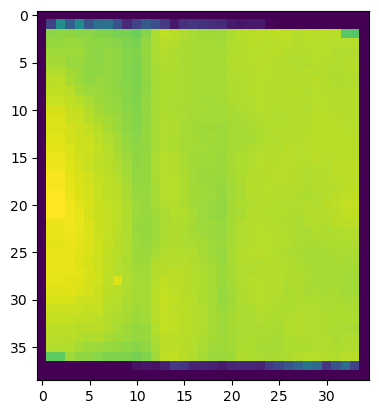

In [15]:
dir = '/Users/hpm5/Documents/Data/nirspec_inspect/'
files = sorted(glob.glob(dir + '/*data.fits'))
im = fits.getdata(files[2], ext=1)

fig, ax= plt.subplots()
print(im.shape)
ax.imshow(np.sum(im, axis=0))

In [16]:
l2dir = dir + '/level2/'
ims = []
ch4ims = []
geos = []
temps = []
dens = []
dtemps = []
ddens = []
l2geos = []
emisss = []
lows = []
sigmas = []

for f in files : 
    name = os.path.basename(f).replace('_data.fits', '')
    l2file = l2dir + name + '.fits'
    print(l2file)
    im = np.sum(fits.getdata(f), axis=0)
    im = im.T
    ims.append(im)


    im = fits.getdata(f, ext = 4)
    print(im.shape)
    im = np.sum(im[0:100, :, :], axis=0)
    im = im.T
    ch4ims.append(im)

    # Load the temperatures
    im = fits.getdata(f.replace('_data.', '_results.'))
    temps.append(im.T)

    # Load the temperatureerrors
    im = fits.getdata(f.replace('_data.', '_results.'), ext = 1)
    dtemps.append(im.T)

    # Load the densities
    im = fits.getdata(f.replace('_data.', '_results.'), ext = 2)
    dens.append(im.T)

    # Load the density errors
    im = fits.getdata(f.replace('_data.', '_results.'), ext = 3)
    ddens.append(im.T)

    # Load the density errors
    im = fits.getdata(f.replace('_data.', '_results.'), ext = 4)
    sigmas.append(im.T)

    # Load the total emission
    im = fits.getdata(f.replace('_data.', '_results.'), ext = 7)
    emisss.append(im.T)

    offset = (-0.7, 0.1)
    l2geo = jssp.JWSTSolarSystemPointing(l2file, radec_offset=offset)
    l2geos.append(l2geo)
    print(l2geo.keys)

    lowim = np.nanmedian(l2geo.im[200:210, :, :], axis=0)
    wave = l2geo.get_wavelength()
    w = np.median(wave[200:210])
    c = 2.99792458e+8
    lowim = lowim / (w * 1e-6)**2 * c * 1.0e-26    
    print(w)

    lows.append(lowim)
    
    geos.append(l2geo.full_fov())
    print(l2geo.im.shape, im.shape)
    if False : 
        fig, ax = plt.subplots()
        ax.imshow(im)
        plt.show()
        plt.close()


/Users/hpm5/Documents/Data/nirspec_inspect//level2/jw01373005001_0310d_00001_nrs1_s3d.fits
(168, 39, 35)
['lat', 'lon', 'lat_limb', 'lon_limb', 'lat_graphic', 'phase', 'emission', 'incidence', 'azimuth', 'localtime', 'distance_limb', 'distance_rings', 'lon_rings', 'ra', 'dec', 'radial_velocity', 'doppler', 'localtime_limb']
2.9962671796530604
(1869, 35, 39) (39, 35)
/Users/hpm5/Documents/Data/nirspec_inspect//level2/jw01373005001_0310f_00001_nrs1_s3d.fits
(168, 39, 35)
['lat', 'lon', 'lat_limb', 'lon_limb', 'lat_graphic', 'phase', 'emission', 'incidence', 'azimuth', 'localtime', 'distance_limb', 'distance_rings', 'lon_rings', 'ra', 'dec', 'radial_velocity', 'doppler', 'localtime_limb']
2.996267163529593
(1869, 35, 39) (39, 35)
/Users/hpm5/Documents/Data/nirspec_inspect//level2/jw01373005001_0310h_00001_nrs1_s3d.fits
(168, 39, 35)
['lat', 'lon', 'lat_limb', 'lon_limb', 'lat_graphic', 'phase', 'emission', 'incidence', 'azimuth', 'localtime', 'distance_limb', 'distance_rings', 'lon_rings'

In [17]:
print('Median sigma', np.median(np.array(sigmas)))
ms = np.median(np.array(sigmas))
measR = 3.4 / ms / np.sqrt(2 * np.pi) 
print(measR)
#value = ( np.mean(self.wavelength) / value ) / np.sqrt(2 * np.pi)




Median sigma 0.000499576797302566
2715.1055867460004


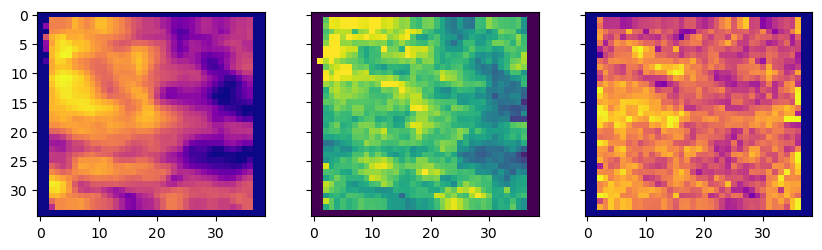

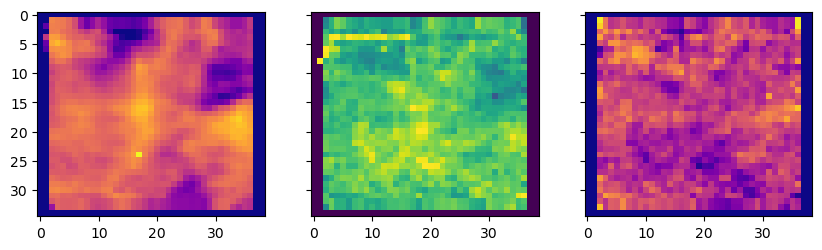

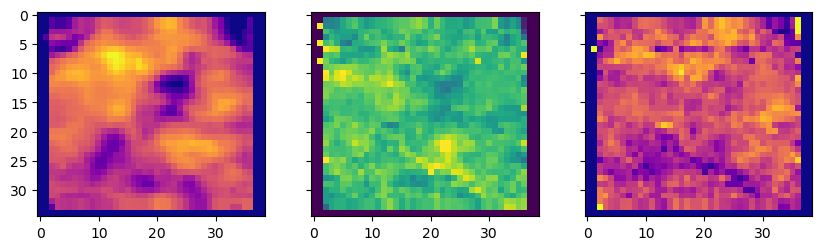

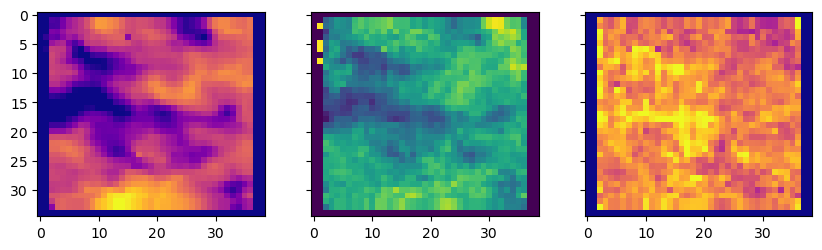

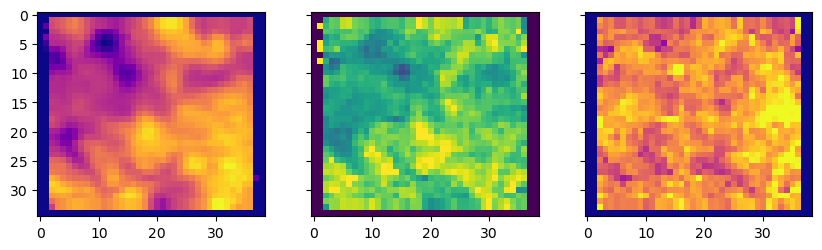

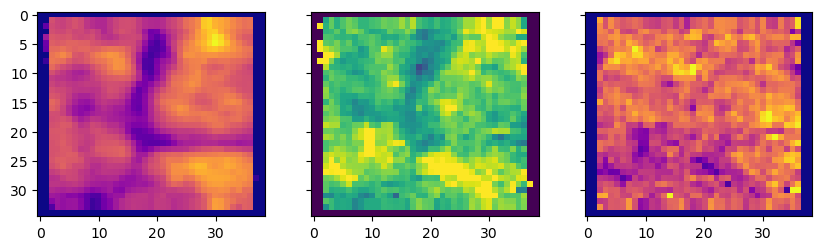

In [18]:
dwave = wave[501] - wave[500]
for nn in range(6) : 
    fig, (ax3, ax1, ax2) = plt.subplots(1, 3, sharey = True, figsize=(10, 3))
    hmap3 = ims[nn] * dwave * 1e6
    imh = ax3.imshow(hmap3, cmap='plasma', vmin=1.9)
    #ax3.set(xlabel = 'IFU $x$ spaxel', ylabel = 'IFU $y$ spaxel')
    #divider = make_axes_locatable(ax3)
    #cax = divider.append_axes("right", size="5%", pad=0.09)
    #fig.colorbar(imh, cax=cax, label = 'H$_3^+$ Integrated Radiance ($\mu$Wm$^{-2}$sr$^{-1}$)')

    imt = ax2.imshow(temps[nn], vmin=650, vmax = 750, cmap = 'plasma')
    imt = ax1.imshow(dens[nn]/1e15, vmin = 1, vmax=4.0)
    plt.savefig('figures/ERS_GRS_rtcd_preview_tile_' + str(nn+1) + '.pdf', bbox_inches = 'tight')

In [19]:

def project_individual_lat_lon(xgrid, ygrid, x, y, im) : 



    # pyresample requires -180 < longitude < 180
    xgrid2 = xgrid.copy()
    xgrid2[xgrid2 > 180] -= 360

    x2 = x.copy()
    x2[x2 > 180] -= 360

    # This is what we are projecting the data onto
    xg, yg = np.meshgrid(xgrid2, ygrid)

    # Do the projection
    targ_def = pyresample.geometry.SwathDefinition(lons = xg, lats = yg)
    orig_def = pyresample.geometry.SwathDefinition(lons = x2.astype('float64'), lats = y.astype('float64'))
    mapped   = pyresample.kd_tree.resample_nearest(orig_def, im, targ_def, radius_of_influence=3e4, fill_value=0, epsilon = 0.5)
    
    return mapped

def mask(im2) : 
    im = im2.copy()
    im[0, :] = 0
    im[1, :] = 0
    im[2, :] = 0
    im[32, :] = 0
    im[33, :] = 0
    im[34, :] = 0
    
    im[:, 0] = 0
    im[:, 1] = 0
    im[:, 2] = 0
    im[:, 36] = 0
    im[:, 37] = 0
    im[:, 38] = 0

    return im


def smallmask(im2) : 
    im = im2.copy()
    im[0, :] = 0
    im[1, :] = 0
  #  im[2, :] = 0
#    #im[32, :] = 0
    im[33, :] = 0
    im[34, :] = 0
    
    im[:, 0] = 0
    im[:, 1] = 0
 #   im[:, 2] = 0
 #   im[:, 36] = 0
    im[:, 37] = 0
    im[:, 38] = 0

    return im


res = 0.05

xgrid = np.arange(278, 313, res)
ygrid = np.arange(-33, -5, res)

xgrid = np.arange(275, 312, res)
ygrid = np.arange(-32, -5, res)

xgrid2 = np.arange(275, 312, res)
ygrid2 = np.arange(-32, -5, res)

maps = project_individual_lat_lon(xgrid, ygrid, geos[0][1, :, :], geos[0][0, :, :], ims[0])
print(geos[0][4, :, :])


# Get the size! 
#maps, x, y = project_lat_lon(ims[0]  , geos[0][1, :, :], geos[0][4, :, :])
maps[:] = 0
cnt = maps.copy()
temp = maps.copy()
den = maps.copy()
dtemp = maps.copy()
dden = maps.copy()
low = maps.copy()
methane = maps.copy()
totemiss = maps.copy()
lowes = []
h3pimaps = []
nbr = 0
for im in ims : 
    im2 = mask(im)
    t = mask(temps[nbr])
    d = mask(dens[nbr])
    dt = mask(dtemps[nbr])
    dd = mask(ddens[nbr])
    l = mask(lows[nbr])
    ch4im = mask(ch4ims[nbr])
    emiss = mask(emisss[nbr])

    # Map to lat/lon
    mapped = project_individual_lat_lon(xgrid, ygrid, geos[nbr][1, :, :], geos[nbr][0, :, :], im2)
    maps += mapped

    mapped2 = project_individual_lat_lon(xgrid, ygrid, geos[nbr][1, :, :], geos[nbr][0, :, :], smallmask(im))
    h3pimaps.append(mapped2)

    ch4mapped = project_individual_lat_lon(xgrid, ygrid, geos[nbr][1, :, :], geos[nbr][0, :, :], ch4im)
    methane += ch4mapped

    emmapped = project_individual_lat_lon(xgrid, ygrid, geos[nbr][1, :, :], geos[nbr][0, :, :], emiss)
    totemiss += emmapped

    temped = project_individual_lat_lon(xgrid, ygrid, geos[nbr][1, :, :], geos[nbr][0, :, :], t)
    temp += temped

    dtemped = project_individual_lat_lon(xgrid, ygrid, geos[nbr][1, :, :], geos[nbr][0, :, :], dt)
    dtemp += dtemped

    dened = project_individual_lat_lon(xgrid, ygrid, geos[nbr][1, :, :], geos[nbr][0, :, :], d)
    den += dened

    ddened = project_individual_lat_lon(xgrid, ygrid, geos[nbr][1, :, :], geos[nbr][0, :, :], dd)
    dden += ddened

    lowed = project_individual_lat_lon(xgrid, ygrid, geos[nbr][1, :, :], geos[nbr][0, :, :], l)
    low += lowed
    lowed = project_individual_lat_lon(xgrid, ygrid, geos[nbr][1, :, :], geos[nbr][0, :, :], lows[nbr])
    lowes.append(lowed)

    wdata = np.where(mapped > 0, 1, 0)
    cnt += wdata
    nbr += 1
    if False : 
        fig, ax = plt.subplots()
        ax.imshow(im)
        plt.show()
        plt.close()

hmap = maps / cnt
tmap = temp / cnt
dmap = den / cnt
dtmap = dtemp / cnt
ddmap = dden / cnt
lmap = low / cnt
methane = methane / cnt
totemiss = totemiss / cnt



[[-20.56594959 -20.75636397 -20.94702404 ... -27.59220064 -27.79300253
  -27.99414823]
 [-20.31629259 -20.50650734 -20.6969646  ... -27.33311536 -27.53358028
  -27.7343843 ]
 [-20.06703815 -20.25705661 -20.44731445 ... -27.0745881  -27.27472161
  -27.4751896 ]
 ...
 [-12.74700593 -12.93250784 -13.11817214 ... -19.53839492 -19.73075899
  -19.92334881]
 [-12.50740154 -12.69279353 -12.87834578 ... -19.29337295 -19.48553925
  -19.67792844]
 [-12.26803235 -12.45331677 -12.63875934 ... -19.04868684 -19.24065873
  -19.43285069]]


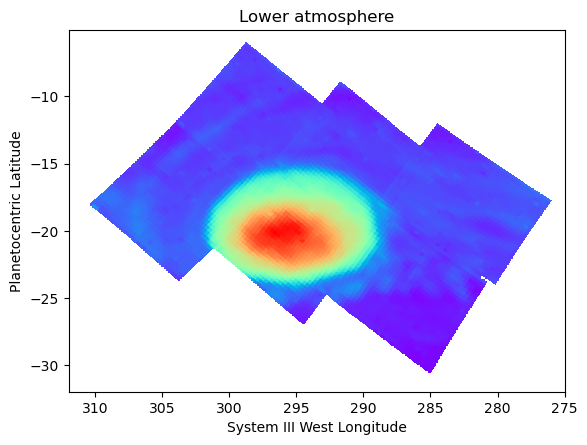

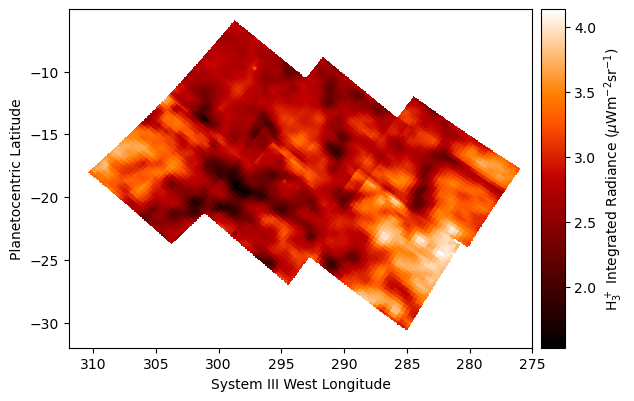

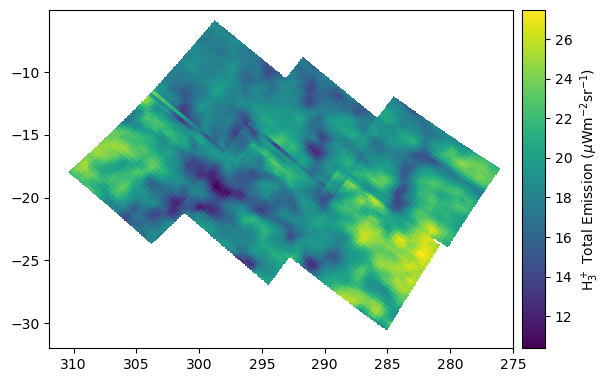

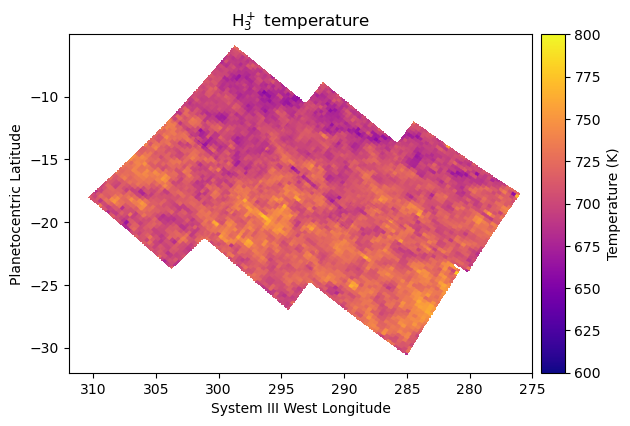

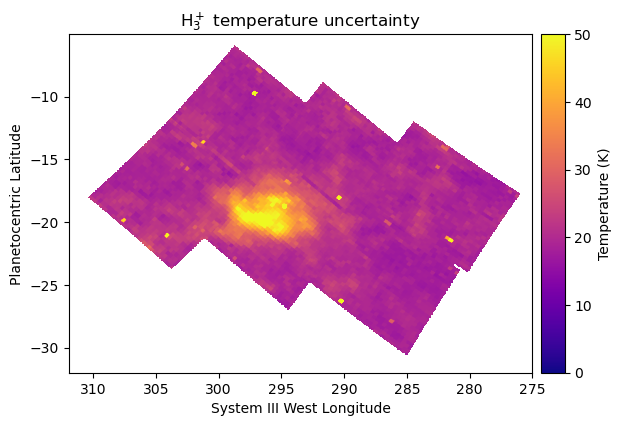

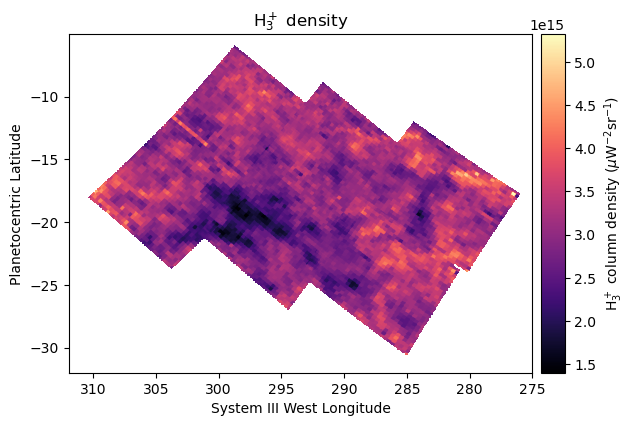

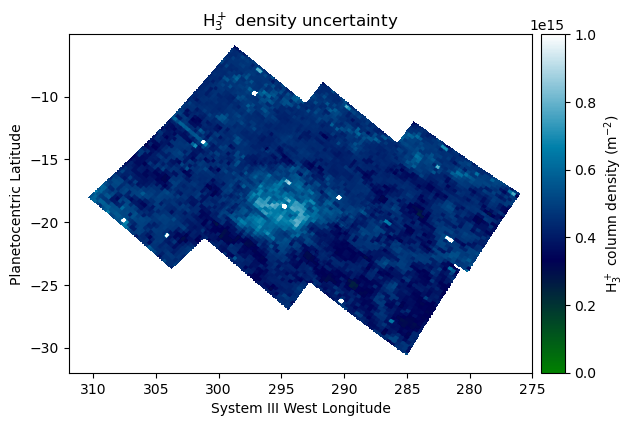

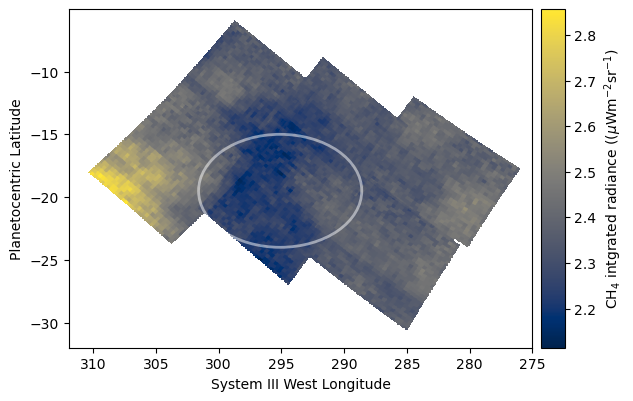

In [20]:
xlabel = 'System III West Longitude'
ylabel = 'Planetocentric Latitude'


fig, ax = plt.subplots() #, figsize = (12, 8))
ex = [np.min(xgrid), np.max(xgrid), np.max(ygrid), np.min(ygrid)]
ax.imshow(lmap, aspect = 'equal', extent = ex, cmap='rainbow')
ax.set(xlim = (np.max(xgrid), np.min(xgrid)))
ax.set(ylim = (np.min(ygrid), np.max(ygrid)))
ax.set(xlabel = xlabel, ylabel = ylabel, title='Lower atmosphere')
plt.savefig('figures/ERS_GRS_lower_atmosphere.pdf')
plt.show()

fits.writeto('output/jupiter_grs/Melin_GRS_lower_atmosphere_map.fits', lmap, overwrite=True)


dwave = wave[301] - wave[300]
fig, ax = plt.subplots() #, figsize = (12, 8))
ex = [np.min(xgrid), np.max(xgrid), np.max(ygrid), np.min(ygrid)]
imh3p = ax.imshow((hmap*dwave)*1e6, aspect = 'equal', extent = ex, cmap='gist_heat')
ax.set(xlim = (np.max(xgrid), np.min(xgrid)))
ax.set(ylim = (np.min(ygrid), np.max(ygrid)))
ax.set(xlabel = xlabel, ylabel = ylabel) #, title='H$_3^+$ intensity')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.09)
fig.colorbar(imh3p, cax=cax, label = 'H$_3^+$ Integrated Radiance ($\mu$Wm$^{-2}$sr$^{-1}$)')
plt.savefig('figures/ERS_GRS_h3p_intensity.pdf', bbox_inches = 'tight')
plt.show()

fits.writeto('output/jupiter_grs/Melin_GRS_H3p_map.fits', (hmap*dwave)*1e6, overwrite = True)


fig, ax = plt.subplots() #, figsize = (12, 8))
ex = [np.min(xgrid), np.max(xgrid), np.max(ygrid), np.min(ygrid)]
imem = ax.imshow(totemiss * 1e6, aspect = 'equal', extent = ex, cmap='viridis')
ax.set(xlim = (np.max(xgrid), np.min(xgrid)))
ax.set(ylim = (np.min(ygrid), np.max(ygrid)))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.09)
fig.colorbar(imem, cax=cax, label = 'H$_3^+$ Total Emission ($\mu$Wm$^{-2}$sr$^{-1}$)')
plt.savefig('figures/ERS_GRS_total_emission.pdf')
plt.show()

fig, ax = plt.subplots() #, figsize = (12, 8))
damap = ax.imshow(tmap, aspect = 'equal', extent = ex, cmap='plasma', vmin = 600, vmax = 800)
ax.set(xlim = (np.max(xgrid), np.min(xgrid)))
ax.set(ylim = (np.min(ygrid), np.max(ygrid)))
ax.set(xlabel = xlabel, ylabel = ylabel, title = 'H$_3^+$ temperature')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.09)
fig.colorbar(damap, cax=cax, label = 'Temperature (K)')
plt.savefig('figures/ERS_GRS_h3p_temperature.pdf')
plt.show()

fig, ax = plt.subplots() #, figsize = (12, 8))
damap = ax.imshow(dtmap, aspect = 'equal', extent = ex, cmap='plasma', vmin = 0, vmax = 50)
ax.set(xlim = (np.max(xgrid), np.min(xgrid)))
ax.set(ylim = (np.min(ygrid), np.max(ygrid)))
ax.set(xlabel = xlabel, ylabel = ylabel, title = 'H$_3^+$ temperature uncertainty')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.09)
fig.colorbar(damap, cax=cax, label = 'Temperature (K)')
plt.savefig('figures/ERS_GRS_h3p_temperature_error.pdf')
plt.show()

fig, ax = plt.subplots() #, figsize = (12, 8))
damap = ax.imshow(dmap, aspect = 'equal', extent = ex, cmap='magma')
ax.set(xlim = (np.max(xgrid), np.min(xgrid)))
ax.set(ylim = (np.min(ygrid), np.max(ygrid)))
ax.set(xlabel = xlabel, ylabel = ylabel, title = 'H$_3^+$ density')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.09)
fig.colorbar(damap, cax=cax, label = 'H$_3^+$ column density ($\mu$W$^{-2}$sr$^{-1}$)')
plt.savefig('figures/ERS_GRS_h3p_density.pdf')
plt.show()

fig, ax = plt.subplots() #, figsize = (12, 8))
damap = ax.imshow(ddmap, aspect = 'equal', extent = ex, cmap='ocean', vmin = 0, vmax= 1e15)
ax.set(xlim = (np.max(xgrid), np.min(xgrid)))
ax.set(ylim = (np.min(ygrid), np.max(ygrid)))
ax.set(xlabel = xlabel, ylabel = ylabel, title = 'H$_3^+$ density uncertainty')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.09)
fig.colorbar(damap, cax=cax, label = 'H$_3^+$ column density (m$^{-2}$)')
plt.savefig('figures/ERS_GRS_h3p_density_error.pdf')
plt.show()

fig, ax = plt.subplots() #, figsize = (12, 8))
damap = ax.imshow(methane * dwave * 1e6, aspect = 'equal', extent = ex, cmap='cividis')
ax.set(xlim = (np.max(xgrid), np.min(xgrid)))
ax.set(ylim = (np.min(ygrid), np.max(ygrid)))
ax.set(xlabel = xlabel, ylabel = ylabel) #, title = 'CH$_4$ Integrated radiance')
ellipse = Ellipse(xy=(295.1, -19.5), width=13, height=9, edgecolor='white', fc='None', lw=2, alpha = 0.5)
ax.add_patch(ellipse)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.09)
fig.colorbar(damap, cax=cax, label = 'CH$_4$ intgrated radiance (($\mu$Wm$^{-2}$sr$^{-1}$)')
plt.savefig('figures/ERS_GRS_h3p_ch4.pdf')
plt.show()


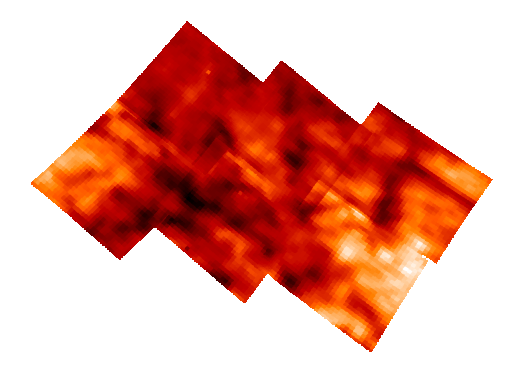

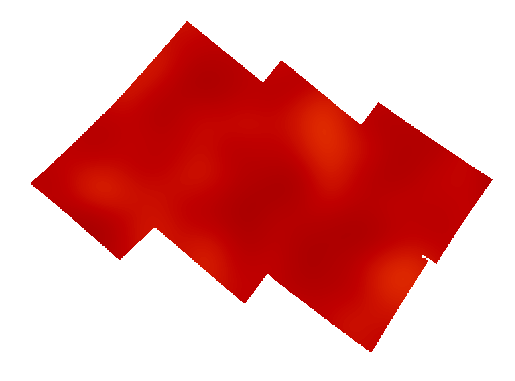

In [9]:
dwave = wave[301] - wave[300]
fig, ax = plt.subplots() #, figsize = (12, 8))
ex = [np.min(xgrid), np.max(xgrid), np.max(ygrid), np.min(ygrid)]
imh3p = ax.imshow((hmap*dwave)*1e6, aspect = 'equal', extent = ex, cmap='gist_heat')
ax.set(xlim = (np.max(xgrid), np.min(xgrid)))
ax.set(ylim = (np.min(ygrid), np.max(ygrid)))
ax.set(xlabel = xlabel, ylabel = ylabel) #, title='H$_3^+$ intensity')
plt.axis('off')
plt.savefig('figures/ERS_GRS_h3p_simple.pdf', bbox_inches = 'tight', transparent = True)


fig, ax = plt.subplots() #, figsize = (12, 8))
ex = [np.min(xgrid), np.max(xgrid), np.max(ygrid), np.min(ygrid)]

tmap2 = hmap.copy()
mask2 = np.where(np.isfinite(tmap2), 1, np.nan)
tmap2[~np.isfinite(tmap2)] = np.nanmedian(tmap2)
for i, line in enumerate(tmap2) : 
    tmap2[i, :] = np.random.normal(50,53,line.shape)
im2 = sp.ndimage.gaussian_filter(tmap2, sigma=30.0, order=0)

imh3p = ax.imshow(im2 * mask2, aspect = 'equal', extent = ex, cmap='gist_heat', vmax = 60, vmin = 40)
ax.set(xlim = (np.max(xgrid), np.min(xgrid)))
ax.set(ylim = (np.min(ygrid), np.max(ygrid)))
ax.set(xlabel = xlabel, ylabel = ylabel) #, title='H$_3^+$ intensity')
plt.axis('off')
plt.savefig('figures/ERS_GRS_h3p_simple_expectation.pdf', bbox_inches = 'tight', transparent = True)


#plt.show()

(68, 93)
(68, 93)
(68, 93)
(68, 93)
(68, 93)
(68, 93)
(68, 93)


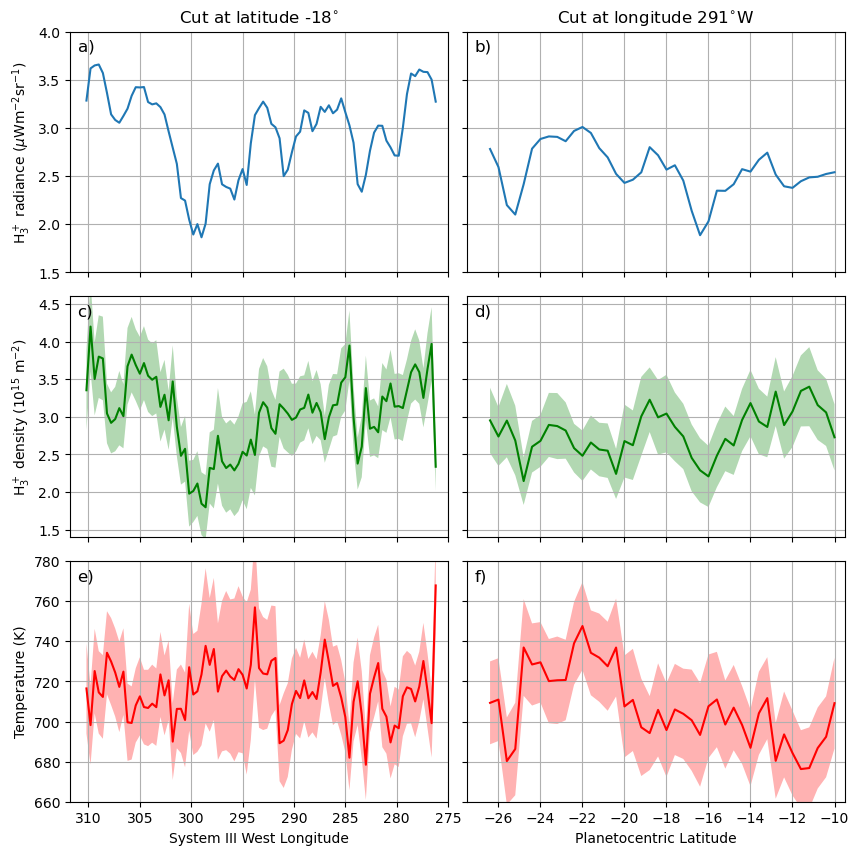

In [10]:
res = 0.4
xgrid2 = np.arange(275, 312, res)
ygrid2 = np.arange(-32, -5, res)

lowmaps = project_individual_lat_lon(xgrid2, ygrid2, geos[0][1, :, :], geos[0][0, :, :], ims[0])

print(lowmaps.shape)
# Get the size! 
#maps, x, y = project_lat_lon(ims[0]  , geos[0][1, :, :], geos[0][4, :, :])
lowmaps[:] = 0
lowcnt = lowmaps.copy()
lowtemp = lowmaps.copy()
lowden = lowmaps.copy()
lowdtemp = lowmaps.copy()
lowdden = lowmaps.copy()
cnt = lowmaps.copy()
nbr = 0
for im in ims : 
    im2 = mask(im)
    t = mask(temps[nbr])
    d = mask(dens[nbr])
    dt = mask(dtemps[nbr])
    dd = mask(ddens[nbr])
    l = mask(lows[nbr])
    ch4im = mask(ch4ims[nbr])
    emiss = mask(emisss[nbr])

    # Map to lat/lon
    mapped = project_individual_lat_lon(xgrid2, ygrid2, geos[nbr][1, :, :], geos[nbr][0, :, :], im2)
    lowmaps += mapped

    temped = project_individual_lat_lon(xgrid2, ygrid2, geos[nbr][1, :, :], geos[nbr][0, :, :], t)
    lowtemp += temped

    dtemped = project_individual_lat_lon(xgrid2, ygrid2, geos[nbr][1, :, :], geos[nbr][0, :, :], dt)
    lowdtemp += dtemped

    dened = project_individual_lat_lon(xgrid2, ygrid2, geos[nbr][1, :, :], geos[nbr][0, :, :], d)
    lowden += dened

    ddened = project_individual_lat_lon(xgrid2, ygrid2, geos[nbr][1, :, :], geos[nbr][0, :, :], dd)
    lowdden += ddened

    wdata = np.where(mapped > 0, 1, 0)
    print(wdata.shape)
    cnt += wdata
    nbr += 1

lowhmap = lowmaps / cnt
lowtmap = lowtemp / cnt
lowdmap = lowden / cnt
lowdtmap = lowdtemp / cnt
lowddmap = lowdden / cnt

nn = 35
im = lowhmap*dwave*1e6
fig, (axs1, axs2, axs3) = plt.subplots(3, 2, figsize= (10, 10))
fig.subplots_adjust(wspace = 0.05, hspace = 0.1)
#ax.imshow(im)
axs1[0].plot(xgrid2, im[nn, :])

axs1[0].set(xlim = (np.max(xgrid2), np.min(xgrid2)), ylabel = 'H$_3^+$ radiance ($\mu$Wm$^{-2}$sr$^{-1}$)', xticklabels = [])
d = lowdmap[nn, :] / 1e15
dd = lowddmap[nn, :] / 1e15
axs2[0].plot(xgrid2, d, color='green')
axs2[0].fill_between(xgrid2, d + dd, d - dd, facecolor='green', alpha = 0.3)
axs2[0].set(ylabel = 'H$_3^+$ density (10$^{15}$ m$^{-2}$)', xlim = (np.max(xgrid2), np.min(xgrid2)), xticklabels = [])
t = lowtmap[nn, :]
dt = lowdtmap[nn, :]
axs3[0].plot(xgrid2, t, color='red')
axs3[0].fill_between(xgrid2, t + dt, t - dt, facecolor='red', alpha = 0.3)
axs3[0].set(xlabel = 'System III West Longitude', ylabel = 'Temperature (K)', xlim = (np.max(xgrid2), np.min(xgrid2)))

nn = 39
xlim = (-27.5, -9.5)
axs1[1].plot(ygrid2, im[:, nn])
axs1[1].set(xlim = xlim, xticklabels = [], yticklabels = [])

d = lowdmap[:, nn] / 1e15
dd = lowddmap[:, nn] / 1e15
axs2[1].plot(ygrid2, d, color='green')
axs2[1].fill_between(ygrid2, d + dd, d - dd, facecolor='green', alpha = 0.3)
axs2[1].set(xlim = xlim, xticklabels = [], yticklabels = [])

t = lowtmap[:, nn] 
dt = lowdtmap[:, nn] 
axs3[1].plot(ygrid2, t, color='red')
axs3[1].fill_between(ygrid2, t + dt, t - dt, facecolor='red', alpha = 0.3)
axs3[1].set(xlim = xlim, yticklabels = [], xlabel = 'Planetocentric Latitude')
axs3[1].xaxis.set_major_locator(MaxNLocator(integer=True))

axs1[0].set(ylim = (1.5, 4), title='Cut at latitude ' + "{:.0f}".format(ygrid2[35])+ '$^{\circ}$')
axs1[1].set(ylim = (1.5, 4), title='Cut at longitude ' + "{:.0f}".format(xgrid2[nn])+ '$^{\circ}$W')
axs2[0].set(ylim = (1.4, 4.6))
axs2[1].set(ylim = (1.4, 4.6))
axs3[0].set(ylim = (660, 780))
axs3[1].set(ylim = (660, 780))

lab = ['a)', 'b)']
for i, ax in enumerate(axs1) : 
    ax.text(0.02, 0.97, lab[i], va='top', fontsize=12, transform=ax.transAxes)
    ax.grid(True)
lab = ['c)', 'd)']
for i, ax in enumerate(axs2) : 
    ax.text(0.02, 0.97, lab[i], va='top', fontsize=12, transform=ax.transAxes)
    ax.grid(True)
lab = ['e)', 'f)']
for i, ax in enumerate(axs3) : 
    ax.text(0.02, 0.97, lab[i], va='top', fontsize=12, transform=ax.transAxes)
    ax.grid(True)
axs3[1].grid(True)
plt.savefig('figures/ERS_GRS_cuts.pdf', bbox_inches = 'tight')



0.06842592592594149
0.036418918918919435
691.0251773656032 730.9220264357537
2.236198726187752 3.446480514295552


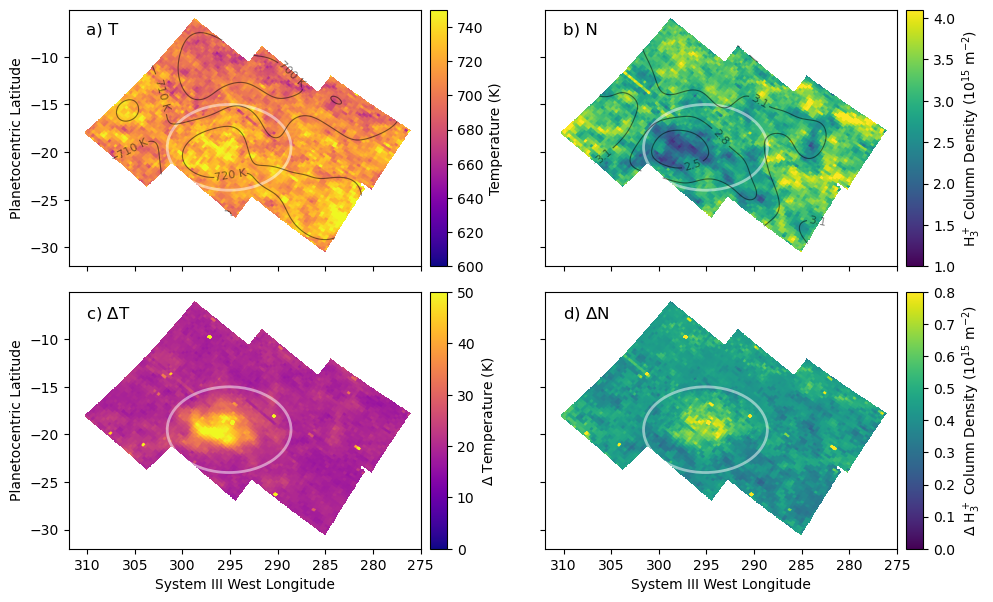

In [23]:
def ax_decorate(fig, ax, damap, clabel, lab) :
    ax.set(xlim = (np.max(xgrid), np.min(xgrid)))
    ax.set(ylim = (np.min(ygrid), np.max(ygrid)))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.09)
    fig.colorbar(damap, cax=cax, label = clabel)
    ax.text(0.05, 0.95, lab, va='top', fontsize=12, transform=ax.transAxes)
    return fig, ax

def smooth(tmap, sm=20) : 
    tmap2 = tmap.copy()
    mask = np.where(np.isfinite(tmap2), 1, np.nan)
    tmap2[~np.isfinite(tmap2)] = np.nanmedian(tmap2)
    im2 = sp.ndimage.gaussian_filter(tmap2, sigma=sm, order=0)
    print(np.min(im2), np.max(im2))
    return im2 * mask

print((ex[1] - ex[0])/ tmap.shape[0])
print((ex[2] - ex[3])/ tmap.shape[1])

fig, (ax1, ax2) = plt.subplots(2, 2, sharex = True, sharey = True, figsize = (12, 7))
fig.subplots_adjust(hspace=0.1, wspace= 0.05)
ax = ax1[0]
damap = ax.imshow(tmap, aspect = 'equal', extent = ex, cmap='plasma', vmin = 600, vmax = 750)
fig, ax = ax_decorate(fig, ax, damap, 'Temperature (K)', 'a) T')
ax.set(ylabel = ylabel)
CS = ax.contour(smooth(tmap, sm=30), levels=np.arange(690, 730, 10), extent = ex, origin='upper', colors='black', alpha = 0.5, linewidths = 0.8)
ax.clabel(CS, CS.levels, inline=True, fmt='%1.0f K', fontsize=8, use_clabeltext=True, inline_spacing = 5)
ellipse = Ellipse(xy=(295.1, -19.5), width=13, height=9, edgecolor='white', fc='None', lw=2, alpha = 0.5)
ax.add_patch(ellipse)

ax = ax2[0]
damap = ax.imshow(dtmap, aspect = 'equal', extent = ex, cmap='plasma', vmin = 0, vmax = 50)
fig, ax = ax_decorate(fig, ax, damap, '$\Delta$ Temperature (K)', 'c) $\Delta$T')
ax.set(xlabel = xlabel, ylabel = ylabel)
#ax.contour(smooth(dtmap, sm=30), levels=np.arange(25, 35, 5), extent = ex, origin='upper', colors='white', alpha = 0.5)
ellipse = Ellipse(xy=(295.1, -19.5), width=13, height=9, edgecolor='white', fc='None', lw=2, alpha = 0.5)
ax.add_patch(ellipse)

ax = ax1[1]
damap = ax.imshow(dmap / 1e15, aspect = 'equal', extent = ex, cmap='viridis', vmin = 1, vmax = 4.1)
fig, ax = ax_decorate(fig, ax, damap, 'H$_3^+$ Column Density (10$^{15}$ m$^{-2}$)', 'b) N')
CS2 = ax.contour(smooth(dmap/1e15, sm=30), levels=np.arange(2.2, 3.4, 0.3), extent = ex, origin='upper', colors='black', alpha = 0.5, linewidths=0.8)
ax.clabel(CS2, CS2.levels, inline=True, fmt='%1.1f', fontsize=8, use_clabeltext=True, inline_spacing = 5)
ellipse = Ellipse(xy=(295.1, -19.5), width=13, height=9, edgecolor='white', fc='None', lw=2, alpha = 0.5)
ax.add_patch(ellipse)

ax = ax2[1]
damap = ax.imshow(ddmap / 1e15, aspect = 'equal', extent = ex, cmap='viridis', vmin = 0.0, vmax = 0.8)
fig, ax = ax_decorate(fig, ax, damap, '$\Delta$ H$_3^+$ Column Density (10$^{15}$ m$^{-2}$)', 'd) $\Delta$N')
ax.set(xlabel = xlabel)
ellipse = Ellipse(xy=(295.1, -19.5), width=13, height=9, edgecolor='white', fc='None', lw=2, alpha = 0.5)
ax.add_patch(ellipse)

plt.savefig('figures/ERS_GRS_tcd_panels.pdf', bbox_inches = 'tight')

fits.writeto('figures/jupiter_grs_h3p/figure4a.fits', tmap, overwrite=True)
fits.writeto('figures/jupiter_grs_h3p/figure4b.fits', dmap, overwrite=True)
fits.writeto('figures/jupiter_grs_h3p/figure4c.fits', dtmap, overwrite=True)
fits.writeto('figures/jupiter_grs_h3p/figure4d.fits', ddmap, overwrite=True)



0.06842592592594149
0.036418918918919435


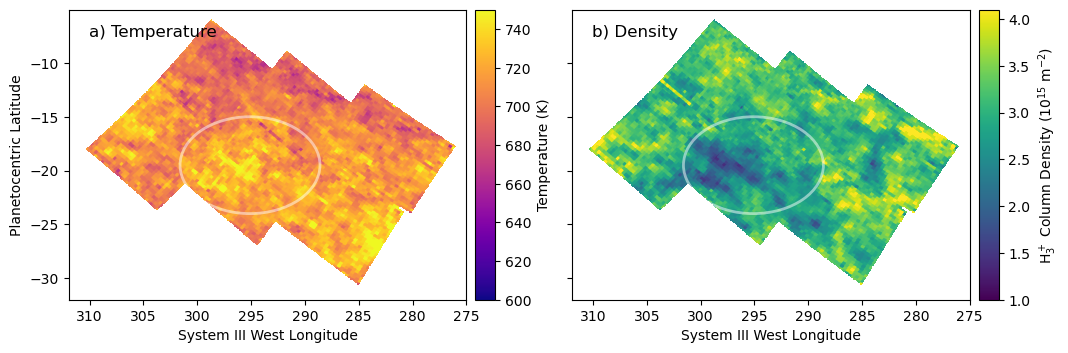

In [12]:
def ax_decorate(fig, ax, damap, clabel, lab) :
    ax.set(xlim = (np.max(xgrid), np.min(xgrid)))
    ax.set(ylim = (np.min(ygrid), np.max(ygrid)))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.09)
    fig.colorbar(damap, cax=cax, label = clabel)
    ax.text(0.05, 0.95, lab, va='top', fontsize=12, transform=ax.transAxes)
    return fig, ax

def smooth(tmap, sm=20) : 
    tmap2 = tmap.copy()
    mask = np.where(np.isfinite(tmap2), 1, np.nan)
    tmap2[~np.isfinite(tmap2)] = np.nanmedian(tmap2)
    im2 = sp.ndimage.gaussian_filter(tmap2, sigma=sm, order=0)
    print(np.min(im2), np.max(im2))
    return im2 * mask

print((ex[1] - ex[0])/ tmap.shape[0])
print((ex[2] - ex[3])/ tmap.shape[1])

fig, ax1 = plt.subplots(1, 2, sharex = True, sharey = True, figsize = (12, 7))
fig.subplots_adjust(hspace=0.1, wspace= 0.18)
ax = ax1[0]
damap = ax.imshow(tmap, aspect = 'equal', extent = ex, cmap='plasma', vmin = 600, vmax = 750)
fig, ax = ax_decorate(fig, ax, damap, 'Temperature (K)', 'a) Temperature')
ax.set(ylabel = ylabel, xlabel = xlabel)
#CS = ax.contour(smooth(tmap, sm=30), levels=np.arange(690, 730, 10), extent = ex, origin='upper', colors='black', alpha = 0.5, linewidths = 0.8)
#ax.clabel(CS, CS.levels, inline=True, fmt='%1.0f K', fontsize=8, use_clabeltext=True, inline_spacing = 5)
ellipse = Ellipse(xy=(295.1, -19.5), width=13, height=9, edgecolor='white', fc='None', lw=2, alpha = 0.5)
ax.add_patch(ellipse)

#ax = ax2[0]
#damap = ax.imshow(dtmap, aspect = 'equal', extent = ex, cmap='plasma', vmin = 0, vmax = 50)
#fig, ax = ax_decorate(fig, ax, damap, '$\Delta$ Temperature (K)', 'c) $\Delta$T')
#ax.set(xlabel = xlabel, ylabel = ylabel)
##ax.contour(smooth(dtmap, sm=30), levels=np.arange(25, 35, 5), extent = ex, origin='upper', colors='white', alpha = 0.5)
#ellipse = Ellipse(xy=(295.1, -19.5), width=13, height=9, edgecolor='white', fc='None', lw=2, alpha = 0.5)
#ax.add_patch(ellipse)

ax = ax1[1]
damap = ax.imshow(dmap / 1e15, aspect = 'equal', extent = ex, cmap='viridis', vmin = 1, vmax = 4.1)
fig, ax = ax_decorate(fig, ax, damap, 'H$_3^+$ Column Density (10$^{15}$ m$^{-2}$)', 'b) Density')
#CS2 = ax.contour(smooth(dmap/1e15, sm=30), levels=np.arange(2.2, 3.4, 0.3), extent = ex, origin='upper', colors='black', alpha = 0.5, linewidths=0.8)
#ax.clabel(CS2, CS2.levels, inline=True, fmt='%1.1f', fontsize=8, use_clabeltext=True, inline_spacing = 5)
ax.set(xlabel = xlabel)

ellipse = Ellipse(xy=(295.1, -19.5), width=13, height=9, edgecolor='white', fc='None', lw=2, alpha = 0.5)
ax.add_patch(ellipse)

#ax = ax2[1]
#damap = ax.imshow(ddmap / 1e15, aspect = 'equal', extent = ex, cmap='viridis', vmin = 0.0, vmax = 0.8)
#fig, ax = ax_decorate(fig, ax, damap, '$\Delta$ H$_3^+$ Column Density (10$^{15}$ m$^{-2}$)', 'd) $\Delta$N')
#ax.set(xlabel = xlabel)
#ellipse = Ellipse(xy=(295.1, -19.5), width=13, height=9, edgecolor='white', fc='None', lw=2, alpha = 0.5)
#ax.add_patch(ellipse)

plt.savefig('figures/ERS_GRS_tcd_panels_no_err.pdf', bbox_inches = 'tight')


711.527268546519 738.0339123887298


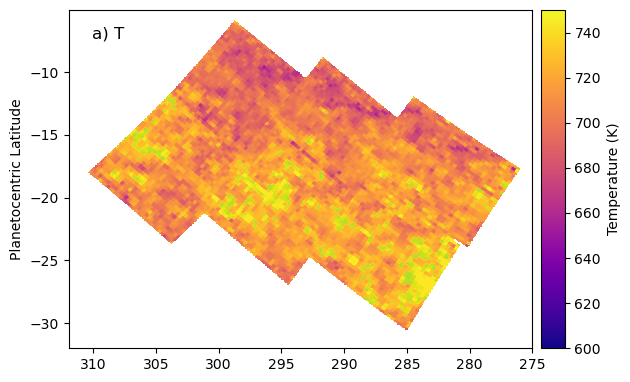

In [13]:
fig, ax = plt.subplots()
damap = ax.imshow(tmap, aspect = 'equal', extent = ex, cmap='plasma', vmin = 600, vmax = 750)
fig, ax = ax_decorate(fig, ax, damap, 'Temperature (K)', 'a) T')
ax.set(ylabel = ylabel)

avt = np.nanmedian(tmap)
davt = np.nanmedian(dtmap)
whp = np.argwhere(tmap > avt + davt)
tmap2 = tmap.copy()
tmap2[tmap < avt + davt] = np.nan
damap = ax.imshow(tmap2, aspect = 'equal', extent = ex, cmap='viridis', vmin = 600, vmax = 750)

print(avt, np.nanmedian(tmap2))


[[711.52726855 711.52726855 711.52726855 ... 711.52726855 711.52726855
  711.52726855]
 [711.52726855 711.52726855 711.52726855 ... 711.52726855 711.52726855
  711.52726855]
 [711.52726855 711.52726855 711.52726855 ... 711.52726855 711.52726855
  711.52726855]
 ...
 [711.52726855 711.52726855 711.52726855 ... 711.52726855 711.52726855
  711.52726855]
 [711.52726855 711.52726855 711.52726855 ... 711.52726855 711.52726855
  711.52726855]
 [711.52726855 711.52726855 711.52726855 ... 711.52726855 711.52726855
  711.52726855]]
737.3390350593855


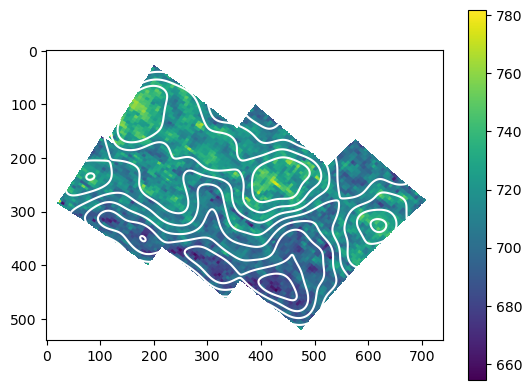

In [14]:
tmap2 = tmap.copy()
mask2 = np.where(np.isfinite(tmap2), 1, np.nan)
tmap2[~np.isfinite(tmap2)] = np.nanmedian(tmap2)
im2 = sp.ndimage.gaussian_filter(tmap2, sigma=20.0, order=0)

fig, ax = plt.subplots()
aa = ax.imshow(tmap)
plt.colorbar(aa)
ax.contour(im2 * mask2, levels = np.arange(690, 730, 5), colors='white')

print(tmap2)
print(np.max(im2))

# Figure 1a

2022-07-27 20:27:10
F444W


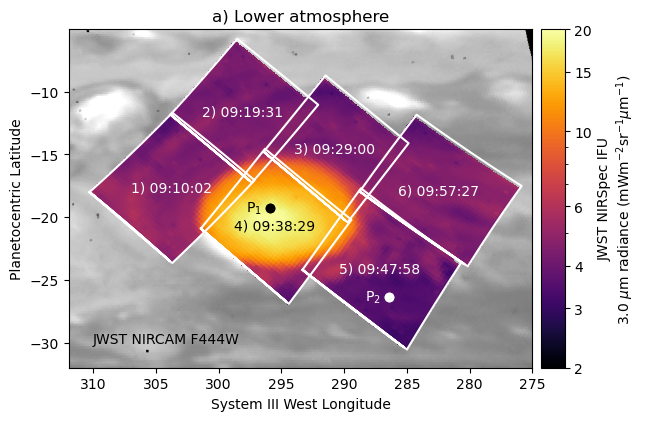

In [9]:
def clean(im) : 
    im_fresh = im.copy()

    for i, x in enumerate(range(im.shape[0])) : 
        y = im[i, :]
        x = np.arange(len(y))
        whz = np.where(y != 0)
        if (x[whz].shape[0] == 0) : continue
        f = interp1d(x[whz], y[whz], fill_value="extrapolate")
        im_fresh[i, :] = f(x)
    return im_fresh 

imfile = '/Users/hpm5/Documents/Data/nirspec_inspect/nircam/jw01373007001_03102_00002_nrcblong_cal.fits'
if False : 
    Jgeo = jssp.JWSTSolarSystemPointing(imfile, target='JUPITER')
    cube_jupiter = Jgeo.full_fov()
    header = Jgeo.data_to_header()
    fits.writeto('models/cube_JUPITER_1.fits', cube_jupiter, header, overwrite = True)
cube_jupiter = fits.getdata('models/cube_JUPITER_1.fits')
Jgeo = jssp.JWSTSolarSystemPointing(imfile, target='JUPITER')
print(Jgeo.obs_mid_iso)
print(Jgeo.dm.meta.instrument.filter)

nircam_map = project_individual_lat_lon(xgrid, ygrid, cube_jupiter[1, :, :], cube_jupiter[0, :, :], clean(Jgeo.im))

fig, ax = plt.subplots()
ax.imshow(nircam_map, extent = ex, cmap='Greys_r', vmin = 0, vmax=32000) #cmap='Greys')
ax.text(310, -30, 'JWST NIRCAM F444W', color='black')
nbr = 0
lmap2 = lmap.copy()
lmap2[lmap2 == 0] = np.nan
fimp = ax.imshow((lmap2 * 1e3), aspect = 'equal', extent = ex, cmap='inferno', norm=colors.LogNorm(vmin=2.0, vmax=20)) #hsv
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.09)
formatter = LogFormatter(10, labelOnlyBase=False) 
cbar = fig.colorbar(fimp, cax=cax, label = "JWST NIRSpec IFU\n3.0 $\mu$m radiance (mWm$^{-2}$sr$^{-1}\mu$m$^{-1}$)", ticks = [2, 3, 4, 6, 10, 15, 20], format = formatter)

for i, geo in enumerate(geos) : 
    ra = geo[1, :, :].copy() #- l2geos[nbr].ra_target
    dec = geo[0, :, :].copy() # - l2geos[nbr].dec_target
    xs = 3
    xe = 32
    ys = 3
    ye = 35
    ra_box = [ra[xs, ys], ra[xe, ys], ra[xe, ye], ra[xs, ye], ra[xs, ys]]
    dec_box = [dec[xs, ys], dec[xe, ys], dec[xe, ye], dec[xs, ye], dec[xs, ys]]
    time = l2geos[nbr].obs_mid_iso.replace('2022-07-27 ', '')
    
    #ax.plot(ra_box, dec_box, label = str(nbr + 1) + '. ' + time[0:8], color='black', alpha = 1.0, linewidth = 1.0)    
    col = 'white'
    if (i == 3) : col = 'black'
    ax.text(np.mean(ra), np.mean(dec), str(nbr + 1) + ') '+ time[0:8], ha = 'center', va = 'center', color=col)
    xs = 3
    xe = 32
    ys = 3
    ye = 35

    ra -= 0.07
    xbox = np.concatenate((ra[xs, ys:ye], ra[xs:xe, ys], ra[xe, ys:ye+1],  np.flip(ra[xs:xe, ye]), ra[xs, ys:ye]))
    ybox = np.concatenate((dec[xs, ys:ye], dec[xs:xe, ys], dec[xe, ys:ye+1], np.flip(dec[xs:xe, ye]), dec[xs, ys:ye]))

    ax.plot(xbox, ybox, color='white', linewidth = 1.5, alpha = 1.0)

    #ax.plot(ra[xs, ys:ye], dec[xs, ys:ye], color='black')
    ##ax.plot(ra[xe, ys:ye], dec[xe, ys:ye], color='black')
    #ax.plot(ra[xs:xe, ys], dec[xs:xe, ys], color='black')
    #ax.plot(ra[xs:xe, ye], dec[xs:xe, ye], color='black')


    nbr += 1
#fig.legend(ncol = 3, bbox_to_anchor=(0.85, 1.01))
ax.set(xlabel = xlabel, ylabel = ylabel)
ax.set(xlim = (np.max(xgrid), np.min(xgrid)))
ax.set(ylim = (np.min(ygrid), np.max(ygrid)))

pc = 'white'
plat = geos[4][0, 12, 25]
plon = geos[4][1, 12, 25]
ax.plot([plon, plon], [plat, plat], 'o', color=pc)
ax.text(plon + 1.3, plat, 'P$_2$', color=pc, va = 'center', ha = 'center')

pc = 'black'
plat = geos[3][0, 20, 15]
plon = geos[3][1, 20, 15]
ax.plot([plon, plon], [plat, plat], 'o', color=pc)
ax.text(plon + 1.3, plat, 'P$_1$', color=pc, va = 'center', ha = 'center')

ax.set(title = 'a) Lower atmosphere')
plt.savefig('figures/ERS_GRS_sequence.pdf', bbox_inches = 'tight')
plt.show()

# Save the data for Data Availability
fits.writeto('figures/jupiter_grs_h3p/figure1a_nirspec.fits', lmap, overwrite=True)
fits.writeto('figures/jupiter_grs_h3p/figure1a_nircam.fits', nircam_map, overwrite=True)


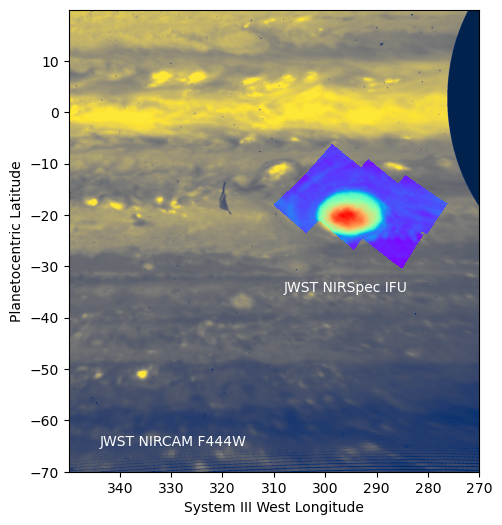

In [16]:
res = 0.05
xgrid2 = np.arange(270, 350, res)
ygrid2 = np.arange(-70, 20, res)
nircam_map = project_individual_lat_lon(xgrid2, ygrid2, cube_jupiter[1, :, :], cube_jupiter[0, :, :], clean(Jgeo.im))
ex2 = [np.min(xgrid2), np.max(xgrid2), np.max(ygrid2), np.min(ygrid2)]

fig, ax = plt.subplots(figsize=(8,6))
ax.imshow(nircam_map, extent = ex2, cmap='cividis', vmin = 0, vmax=37000)
ax.text(344, -65, 'JWST NIRCAM F444W', color='white')
lmap2 = lmap.copy()
lmap2[lmap2 == 0] = np.nan

#fig.legend(ncol = 3, bbox_to_anchor=(0.85, 1.01))
ax.set(xlabel = xlabel, ylabel = ylabel)
ax.set(xlim = (np.max(xgrid2), np.min(xgrid2)))
ax.set(ylim = (np.min(ygrid2), np.max(ygrid2)))
fimp = ax.imshow(lmap2 * 1e3, extent = ex, cmap='rainbow', alpha = 0.0)
plt.savefig('figures/ERS_GRS_sequence_wide_empty.pdf', bbox_inches = 'tight')

fimp = ax.imshow(lmap2 * 1e3, extent = ex, cmap='rainbow', alpha = 1.0)
ax.text(308, -35, 'JWST NIRSpec IFU', color='white')

plt.savefig('figures/ERS_GRS_sequence_wide.pdf', bbox_inches = 'tight')

plt.show()

48704.496
-33301.59


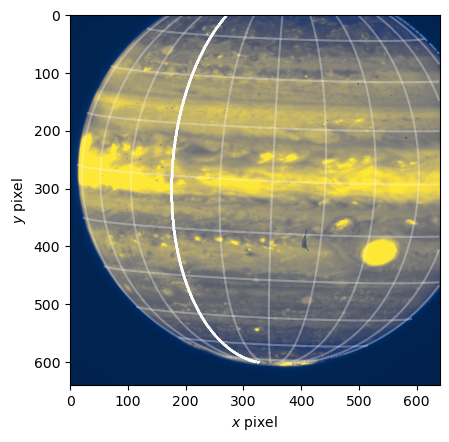

In [17]:
fig, ax = plt.subplots()

im = np.flip(np.rot90(clean(Jgeo.im)), axis=0)
lat = np.flip(np.rot90(cube_jupiter[0, :, :]), axis=0)
lon = np.flip(np.rot90(cube_jupiter[1, :, :]), axis=0)
print(np.max(im))
print(np.min(im))
ax.imshow(im, cmap = 'cividis', vmin = 0, vmax=37000)
ax.contour(lat, levels=np.arange(-90, 90, 15), colors='white', alpha = 0.3, linestyles='solid')
ax.contour(lon, levels=np.arange(0, 360, 15), colors='white', alpha = 0.3, linestyles='solid')
ax.set(xlabel = '$x$ pixel', ylabel = '$y$ pixel')
plt.savefig('figures/ERS_GRS_F444W.pdf', bbox_inches='tight')

/Users/hpm5/anaconda3/envs/jwst/lib/python3.11/site-packages/h3ppy
54.766797381989434
273.8664167478696
8.613213578459408 18.69234672603135
Lat/lon range of observations
311.756911217013 274.7538250938093
37.00308612320367
-4.904382918508241 -31.945325116423007
27.040942197914767


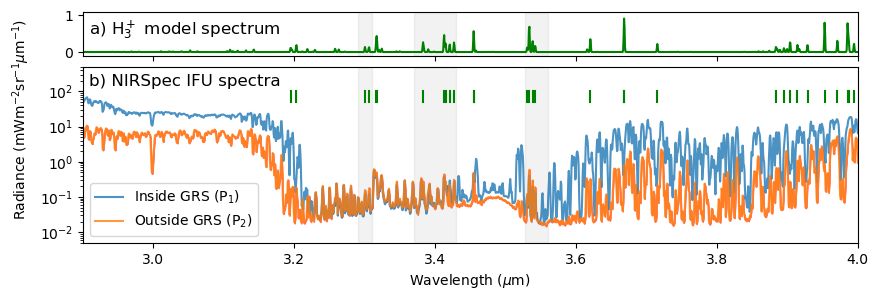

In [21]:
# Example spectrum
spec = l2geos[4].im[:, 12, 25]
spec2 = l2geos[3].im[:, 20, 15]
err = l2geos[0].dm.err[:, 10, 10]
wave = l2geos[0].get_wavelength()
c = 2.99792458e+8
spec = spec / (wave * 1e-6)**2 * c * 1.0e-26  
spec2 = spec2 / (wave * 1e-6)**2 * c * 1.0e-26  
err = err / (wave * 1e-6)**2 * c * 1.0e-26  

h3p = h3ppy.h3p(line_list_file = 'models/h3p_line_list_neale_1996_subset.txt')
h3p.set(temperature = 700, density = 5e15, R=2700, wavelength = wave)
m = h3p.model()

plat = geos[0][0, 10, 10]
plon = geos[1][1, 10, 10]

fig, (ax0, ax) = plt.subplots(2, 1, figsize = (10, 3), gridspec_kw={'height_ratios': [1, 4]}, sharex=True)
fig.subplots_adjust(hspace=0.1)
ax0.plot(wave, m * 1e3, color='green', label = 'H$_3^+$ model')
ax0.set(ylim = (-0.1, 1.1))
#ax0.text(0.008, 0.85, 'a) H$_3^+$ model', fontsize=12, va='top', bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0, alpha = 0.8), transform=ax0.transAxes)
#ax.text(0.008, 0.96, 'b) NIRSpec data', fontsize=12, va='top', bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0, alpha = 0.8), transform=ax.transAxes)

ax0.text(0.008, 0.85, 'a) H$_3^+$ model spectrum', fontsize=12, va='top', transform=ax0.transAxes)
ax.text(0.008, 0.96, 'b) NIRSpec IFU spectra', fontsize=12, va='top', transform=ax.transAxes)

ax.text(-0.08, 0.7, h3p.ylabel(prefix = 'm').replace('Intensity', 'Radiance'), fontsize=10, va='center', transform=ax.transAxes, ha = 'center', rotation = 90)


ax.plot(wave, spec2 * 1e3, label='Inside GRS (P$_1$)', alpha = 0.8)
ax.plot(wave, spec * 1e3, label='Outside GRS (P$_2$)', alpha = 0.8)

ax.fill_between(wave, (spec + err)*1e3, (spec - err) * 1e3, alpha = 0.5, color='red')
#ax.plot(wave, m * 1e3 + 0.0, color='orange', label = 'H$_3^+$ model', alpha = 0.5)
ax.set(xlabel = h3p.xlabel())
ax.set(yscale = 'log', xlim = (2.9, 4.0), ylim=(5e-3, 5e2))
ax.legend()
#    if (i == 0) : whl = np.argwhere((wave > 3.29) & (wave < 3.31))
#    if (i == 1) : whl = np.argwhere((wave > 3.37) & (wave < 3.4))
#    if (i == 2) : whl = np.argwhere((wave > 3.4) & (wave < 3.43))
#    if (i == 3) : whl = np.argwhere((wave > 3.528) & (wave < 3.56))


#ax.axvspan(3.25, 3.6, color='grey', alpha = 0.1)

ax.axvspan(3.29, 3.31, color='grey', alpha = 0.1)
ax.axvspan(3.37, 3.43, color='grey', alpha = 0.1)
ax.axvspan(3.528, 3.56, color='grey', alpha = 0.1)


ax0.axvspan(3.29, 3.31, color='grey', alpha = 0.1)
ax0.axvspan(3.37, 3.43, color='grey', alpha = 0.1)
ax0.axvspan(3.528, 3.56, color='grey', alpha = 0.1)

#ax0.axvspan(3.25, 3.6, color='grey', alpha = 0.1)

int = h3p.line_intensity / np.max(h3p.line_intensity)
hwave = 10000.0 / h3p.line_data['wl']
whl = np.argwhere((int > 0.1) & (hwave > np.min(wave)) & (hwave < 4.1))
for wl in whl : 
    ax.plot([hwave[wl], hwave[wl]], [50, 100], color='green')

plt.savefig('figures/ERS_GRS_example_spectrum_raw.pdf', bbox_inches = 'tight')



whl = np.argwhere((wave > 3.3) & (wave < 3.6))
print(np.mean(spec[whl]/err[whl]))
whl = np.argwhere((wave > 2.95) & (wave < 3.05))
print(np.mean(spec[whl]/err[whl]))

whl = np.argwhere((wave > 3.6) & (wave < 4.0))

print(np.max(spec[whl]) * 1e3, np.max(spec2[whl]) * 1e3)
print('Lat/lon range of observations')
print(np.max(geos[0][1, :, :]) , np.min(geos[5][1, :, :]))
print(np.max(geos[0][1, :, :]) - np.min(geos[5][1, :, :]))

print(np.max(geos[1][0, :, :]) , np.min(geos[4][0, :, :]))
print(np.max(geos[1][0, :, :]) - np.min(geos[4][0, :, :]))

fits.writeto('figures/jupiter_grs_h3p/figure2_wavelength.fits', wave, overwrite=True)
fits.writeto('figures/jupiter_grs_h3p/figure2a_h3p.fits', m, overwrite=True)
fits.writeto('figures/jupiter_grs_h3p/figure2b_p1.fits', spec2, overwrite=True)
fits.writeto('figures/jupiter_grs_h3p/figure2b_p2.fits', spec, overwrite=True)





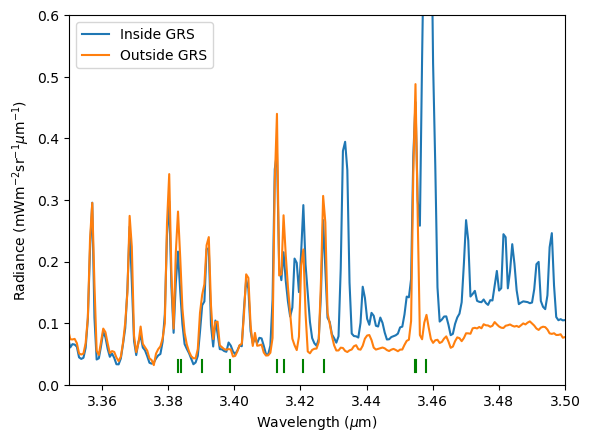

In [19]:
fig, ax = plt.subplots()
ax.plot(wave, spec2*1e3, label = 'Inside GRS')
ax.plot(wave, spec*1e3, label = 'Outside GRS')
ax.set(xlim = (3.35, 3.5), ylim = (0, 0.6))
ax.set(ylabel = h3p.ylabel(prefix = 'm').replace('Intensity', 'Radiance'), xlabel = h3p.xlabel())
ax.legend()
int = h3p.line_intensity / np.max(h3p.line_intensity)
hwave = 10000.0 / h3p.line_data['wl']
whl = np.argwhere((int > 0.01) & (hwave > np.min(wave)) & (hwave < 4.1))
for wl in whl : 
    ax.plot([hwave[wl], hwave[wl]], [0.02, 0.04], color='green')
plt.savefig('figures/ERS_GRS_zoom.pdf', bbox_inches = 'tight')

In [20]:
nbr = 0
for geo in geos : 
    lons = geo[1, :, :] #- l2geos[nbr].ra_target
    lats = geo[0, :, :] # - l2geos[nbr].dec_target
    lts = geo[9, :, :] # - l2geos[nbr].dec_target
    time = l2geos[nbr].obs_mid_iso.replace('2022-07-27 ', '')
    obs_start = l2geos[nbr].obs_start.replace('T', ' ')[0:19]
    obs_end = l2geos[nbr].obs_end.replace('2022-07-27T', '')[:8]
    obs_mid = l2geos[nbr].obs_mid_iso.replace('2022-07-27 ', '')
    centre_lat = '{:.1f}'.format(np.mean(lats))
    centre_lon = '{:.1f}'.format(np.mean(lons))
    centre_lt = '{:.1f}'.format(np.mean(lts))
    sep = ' & '
    print(nbr+1, sep, obs_start, sep, obs_end, sep, obs_mid, sep, centre_lon, sep, centre_lat, sep, centre_lt, '\\\\')
    nbr += 1
#print(l2geos[0].dm.search('crds'))

#print(l2geos[0].dm.search('calibration'))
#print(dir(l2geos[0].dm.meta.exposure))
print(l2geos[0].dm.meta.exposure.ngroups)
print(l2geos[0].dm.meta.exposure.nints)
print(l2geos[0].dm.meta.exposure.effective_exposure_time/60.0)
print(l2geos[0].dm.meta.exposure.nframes)

print('ref_file', l2geos[0].dm.meta.ref_file.crds.items)
#help(l2geos[0].dm.meta.ref_file.crds)

print((l2geos[5].et_end - l2geos[0].et_start)/60.0)

d1 = (l2geos[1].et_start - l2geos[0].et_end)/60.0
d2 = (l2geos[2].et_start - l2geos[1].et_end)/60.0
d3 = (l2geos[3].et_start - l2geos[2].et_end)/60.0
d4 = (l2geos[4].et_start - l2geos[3].et_end)/60.0
d5 = (l2geos[5].et_start - l2geos[4].et_end)/60.0

print(d1, d2, d3, d4, d5)
print(np.mean([d1, d2, d3, d4, d5]))
wave = l2geos[0].get_wavelength()
print(np.max(wave), np.min(wave))

m = np.ma.masked_equal(temp.flatten(), 0)
whg = np.argwhere((m > 600) & (m < 800))
print('T', np.ma.median(m[whg]), np.std(m[whg]))
print(np.ma.min(m), np.ma.max(m))

m = np.ma.masked_equal(dtemp.flatten(), 0)
print('dT', np.median(m[whg]), np.std(m[whg]))
print(np.ma.min(m), np.ma.max(m))

m = np.ma.masked_equal(den.flatten(), 0)
print('N', np.median(m[whg]) / 1e15, np.std(m[whg]) / 1e15)
print(np.ma.min(m), np.ma.max(m))

m = np.ma.masked_equal(dden.flatten(), 0)
print('dN', np.median(m[whg]) / 1e15, np.std(m) / 1e15)
print(np.ma.min(m), np.ma.max(m))


print('km per 0.1 arcsec', 139820.0 / 44.55190 / 10.0)

nbr = 0
for geo in geos : 
    obs_start = l2geos[nbr].obs_start.replace('T', ' ')[0:19]
    print(nbr+1, sep, obs_start, sep, l2geos[nbr].dm.meta.observation.obs_id, sep)


    nbr +=1

1  &  2022-07-27 09:07:15  &  09:12:48  &  09:10:02  &  303.8  &  -17.7  &  11.0 \\
2  &  2022-07-27 09:16:44  &  09:22:17  &  09:19:31  &  298.1  &  -11.6  &  11.8 \\
3  &  2022-07-27 09:26:13  &  09:31:46  &  09:29:00  &  290.8  &  -14.6  &  12.7 \\
4  &  2022-07-27 09:35:42  &  09:41:15  &  09:38:29  &  295.6  &  -20.7  &  12.7 \\
5  &  2022-07-27 09:45:11  &  09:50:44  &  09:47:58  &  287.1  &  -24.1  &  13.7 \\
6  &  2022-07-27 09:54:40  &  10:00:13  &  09:57:27  &  282.5  &  -17.9  &  14.4 \\
30
1
5.368383333333333
1
ref_file <bound method ObjectNode.items of <stdatamodels.properties.ObjectNode object at 0x2ed5f40d0>>
52.96916665037473
3.9374666651089987 3.936383330821991 3.93746666709582 3.936383330821991 3.93746666709582
3.937033332188924
4.102494678940403 2.86027467974067
T 711.5796139578551 17.34534361763953
654.4628509549972 2170.140554011832
dT 19.91338235526213 21.1707409920417
15.976729680261036 1159.8670310426082
N 3.094354934562779 0.4699901564935795
1400468886003375.2 

In [21]:
#types = {'names' : ( 'Ju', 'wu', 'wl', 'EA', 'gw' ), 'formats' : ('f', 'f', 'f', 'f', 'f') }
#h3p('models/h3p_line_list_neale_1996_subset.txt', skiprows=1, dtype = types)

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

h3p = h3ppy.h3p(line_list_file = 'models/h3p_line_list_neale_1996_subset.txt')
wave = h3p.wavegen(3.2, 3.8, 1000)
h3p.set(T = 700, N = 1e16, R = 2700, w = wave)
m = h3p.model()
il = h3p.line_intensity
il = il / max(il)

lines = np.genfromtxt('models/h3p_lines.txt', dtype = str)
print(lines.shape)
div = ' & '
nbr = 1
for line in lines : 
#    print(line)
    wls = 10000.0 / h3p.line_data['wl']
    whl = np.argwhere((il > 0.00001)).flatten()
    nearest, idx = find_nearest(wls[whl], float(line[2]))
#    print(nearest, line[2], il[whl[idx]])

#    whl = np.argwhere()
    assignment = str(line[0]) + ' ' + str(line[1])
    assignment = assignment.replace('^', '$^').replace('-', '-$').replace('+', '+$')
    wl = wls[whl[idx]]
    wl = f"{wl:.4f}"

    wu = h3p.line_data['wu'][whl[idx]]
    wu = f"{wu:.2f}"
    strength = line[3]
    band = ''
    for i in range(4, 7) : 
        band = band + str(line[i])

    print(nbr, div, wl, div, wu, div,  assignment, div, "$" + band + "$", '\\\\')
    nbr += 1


/Users/hpm5/anaconda3/envs/jwst/lib/python3.11/site-packages/h3ppy
(21, 7)
1  &  3.3005  &  3799.29  &  R(4, 1$^+$)  &  $\nu_2(1)\leftarrow0$ \\
2  &  3.3019  &  7827.25  &  R(7, 3$^-$)  &  $\nu_2(1)\leftarrow0$ \\
3  &  3.3063  &  3728.91  &  R(7, 4$^-$)  &  $\nu_2(1)\leftarrow0$ \\
4  &  3.3063  &  5423.23  &  R(4, 2$^+$)  &  $\nu_2(1)\leftarrow0$ \\
5  &  3.3839  &  6921.09  &  R(5, 5$^-$)  &  $\nu_2(1)\leftarrow0$ \\
6  &  3.3839  &  3820.01  &  R(5, 4$^-$)  &  $\nu_2(1)\leftarrow0$ \\
7  &  3.3905  &  8908.35  &  R(5, 3$^-$)  &  $\nu_2(1)\leftarrow0$ \\
8  &  3.3988  &  4065.20  &  R(5, 2$^+$)  &  $\nu_2(1)\leftarrow0$ \\
9  &  3.4077  &  8301.55  &  R(5, 1$^-$)  &  $\nu_2(1)\leftarrow0$ \\
10  &  3.4081  &  5746.89  &  R(3, 3$^+$)  &  $2\nu_2(2)\leftarrow\nu_2(1)$ \\
11  &  3.4128  &  3382.93  &  R(3, 0$^-$)  &  $\nu_2(1)\leftarrow0$ \\
12  &  3.4149  &  3359.00  &  R(3, 1$^+$)  &  $\nu_2(1)\leftarrow0$ \\
13  &  3.4207  &  3287.26  &  R(3, 2$^+$)  &  $\nu_2(1)\leftarrow0$ \\
14 

In [22]:
h3p = h3ppy.h3p(line_list_file = 'models/h3p_line_list_neale_1996_subset.txt')
wave = h3p.wavegen(3.2, 3.8, 1000)
h3p.set(T = 700, N = 1e16, R = 2700, w = wave)
cd = 1e16
m = h3p.model()
il = h3p.line_intensity
il = il / max(il)
wls = 10000.0 / h3p.line_data['wl']

whl1 = np.argwhere((wls > 3.29) & (wls < 3.31)).flatten()
whl2 = np.argwhere((wls > 3.37) & (wls < 3.4)).flatten()
whl3 = np.argwhere((wls > 3.4) & (wls < 3.43)).flatten()
whl4 = np.argwhere((wls > 3.528) & (wls < 3.56)).flatten()

whls = [whl1, whl2, whl3, whl4]
nbr = 1
div = ' & '
for whw in whls : 
#    print(wls[whw])
    for wh in whw : 
        if (il[wh] > 0.005) : 
            wl = wls[wh]
            wu = h3p.line_data['wu'][wh]
            wn = h3p.line_data['wl'][wh]
            ea = h3p.line_data['EA'][wh]
            Ju = h3p.line_data['Ju'][wh]
            gw = h3p.line_data['gw'][wh]
            li = h3p.line_intensity[wh] * cd * 1e6
            print(nbr, div, f"{wl:.4f}", div, f"{wn:.1f}", div, f"{wu:.1f}", div, f"{ea:.1f}", div, int(Ju), div, int(gw), div, f"{li:.3f}" , ' \\\\')
            nbr += 1


/Users/hpm5/anaconda3/envs/jwst/lib/python3.11/site-packages/h3ppy


TypeError: 'numpy.ndarray' object is not callable

(168, 39, 35)
(526, 1)
0 (30, 1)
1 (45, 1)
2 (45, 1)
3 (48, 1)
-0.006286098255954177
1.078421717626522e-16
2.9689231947501704
Power_divergenceResult(statistic=-0.006286099265059941, pvalue=1.0)
0.004184829261716489 0.004184829933506001


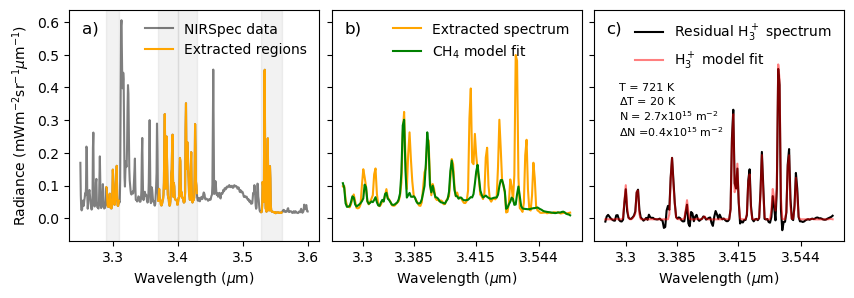

In [22]:


def get_data_products(dir, nbr, x, y) : 
    dfiles = sorted(glob.glob(dir + '/*data*'))
    residual = fits.getdata(dfiles[nbr])
    data = fits.getdata(dfiles[nbr], ext = 1)
    ch4fit = fits.getdata(dfiles[nbr], ext=2)
    wave = fits.getdata(dfiles[nbr], ext=3)
    ch4only = fits.getdata(dfiles[nbr], ext=4)
    print(residual.shape)
    return residual[:, y, x], data[:, y, x], ch4fit[:, y, x], wave[:, y, x], ch4only[:, y, x]
    #return residual[:, y, x], data[:, y, x], ch4fit[:, y, x], wave[:, y, x], ch4only[:, y, x]

#spec = l2geos[4].im[:, 12, 25]
#spec2 = l2geos[3].im[:, 20, 15]
res, dat, fit, fwave, ch4o = get_data_products(dir, 4, 15, 12)

spec = l2geos[4].im[:, 12, 15]
wave = l2geos[4].get_wavelength()
spec = spec / (wave * 1e-6)**2 * c * 1.0e-26  
whw = np.argwhere((wave > 3.25) & (wave < 3.6))
print(whw.shape)
spec = spec[whw[:, 0]]
wave = wave[whw[:, 0]]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 3), sharey = True)
fig.subplots_adjust(wspace=0.05)

ax1.plot(wave, spec * 1e3, color='black', alpha = 0.5, label = 'NIRSpec data')
ax1.set(ylabel = h3p.ylabel(prefix = 'm').replace('Intensity', 'Radiance'), xlabel = h3p.xlabel())
for i in range(4) : 
    if (i == 0) : whl = np.argwhere((wave > 3.29) & (wave < 3.31))
    if (i == 1) : whl = np.argwhere((wave > 3.37) & (wave < 3.4))
    if (i == 2) : whl = np.argwhere((wave > 3.4) & (wave < 3.43))
    if (i == 3) : whl = np.argwhere((wave > 3.528) & (wave < 3.56))
    if (i == 0) : ax1.plot(wave[whl], spec[whl] * 1e3, color='orange', label = 'Extracted regions')
    else : ax1.plot(wave[whl], spec[whl] * 1e3, color='orange')
    print(i, whl.shape)
ax1.legend(frameon = False)

#    if (i == 0) : whl = np.argwhere((wave > 3.29) & (wave < 3.31))
#    if (i == 1) : whl = np.argwhere((wave > 3.37) & (wave < 3.4))
#    if (i == 2) : whl = np.argwhere((wave > 3.4) & (wave < 3.43))
#    if (i == 3) : whl = np.argwhere((wave > 3.528) & (wave < 3.56))

ax1.axvspan(3.29, 3.31, color='grey', alpha = 0.1)
ax1.axvspan(3.37, 3.4, color='grey', alpha = 0.1)
ax1.axvspan(3.4, 3.43, color='grey', alpha = 0.1)
ax1.axvspan(3.528, 3.56, color='grey', alpha = 0.1)

wls = [(3.31 + 3.29)/2, (3.4 + 3.37)/2, (3.43 + 3.4)/2, (3.56 + 3.528)/2]
lens = [30/2, 30 + 45/2, 30 + 45 + 45/2, 30 + 45*2 + 48/2]



#ax.plot(res)
ax2.plot(fit * 1e3, label = 'Extracted spectrum', color='orange')
ax2.set(xlabel = h3p.xlabel())
ax2.plot(dat * 1e3, label = 'CH$_4$ model fit', color='green')
ax2.legend(frameon = False, loc = 'upper right')
ax2.set(xticks = lens, xticklabels = wls)
ax3.set(xticks = lens, xticklabels = wls)

h3p.set(wavelength = fwave, temperature = 700, density = 5e15, R= 2700, data = res, background = 0)
hfit = h3p.fit()
vars, errs = h3p.get_results()
ax3.plot(res* 1e3, label = 'Residual H$_3^+$ spectrum', color='black')
ax3.plot(hfit*1e3, label = 'H$_3^+$ model fit', color='red', alpha = 0.5)
ax3.set(xlabel = h3p.xlabel())
ax3.legend(frameon = False, prop={'size': 10})

ax1.text(0.05, 0.95, 'a)', fontsize=12, verticalalignment='top', transform=ax1.transAxes)#, bbox=dict(facecolor='0.9', edgecolor='none', pad=3.0, alpha = 0.8))
ax2.text(0.05, 0.95, 'b)', fontsize=12, verticalalignment='top', transform=ax2.transAxes)#, bbox=dict(facecolor='0.9', edgecolor='none', pad=3.0, alpha = 0.8))
ax3.text(0.05, 0.95, 'c)', fontsize=12, verticalalignment='top', transform=ax3.transAxes)#, bbox=dict(facecolor='0.9', edgecolor='none', pad=3.0, alpha = 0.8))

#ax1.text(0.05, 0.95, 'a)', fontsize=10, verticalalignment='top', transform=ax1.transAxes, bbox=dict(facecolor='0.9', edgecolor='none', pad=3.0, alpha = 0.8))
#ax3.text(0.05, 0.95, 'c)', fontsize=10, verticalalignment='top', transform=ax3.transAxes, bbox=dict(facecolor='0.9', edgecolor='none', pad=3.0, alpha = 0.8))
##ax2.text(0.05, 0.95, 'b)', fontsize=10, verticalalignment='top', transform=ax2.transAxes, bbox=dict(facecolor='0.9', edgecolor='none', pad=3.0, alpha = 0.8))


dunit = 'x10$^{15}$ m$^{-2}$'
ttext = "T = {:.0f}".format(vars['temperature']) + " K\n$\Delta$T = " + "{:.0f}".format(errs['temperature']) + " K\n"
ttext = ttext + "N = {:.1f}".format(vars['density']/1e15) + dunit + "\n$\Delta$N =" + "{:.1f}".format(errs['density']/1e15) + dunit
ax3.text(0.1, 0.45, ttext, transform=ax3.transAxes, fontsize = 8)
#x3.text(0.1, 0.63, dtext, transform=ax3.transAxes, fontsize = 8)

#ax.plot(ch4o)
plt.savefig('figures/ERS_GRS_fitting.pdf', bbox_inches = 'tight')

def cs(n, y):
    return sp.stats.chisquare(n,  f_exp = np.sum(n)/np.sum(y) * y)

print(np.sum(np.power(res - hfit, 2) / hfit))
print(np.power(np.sum(res) - np.sum(hfit), 2) / np.sum(hfit))
sigma = res * 1.5
print(np.sum((res - hfit)**2 / sigma**2) / float(res.shape[0] - 1)) 
#print(sp.stats.chisquare(res, f_exp = hfit))
print(cs(res, hfit))
print(np.sum(res), np.sum(hfit))
#fig, ax = plt.subplots()
#ax.plot(res)
#ax.plot(hfit)

fits.writeto('figures/jupiter_grs_h3p/figure3a_wavelength.fits', wave, overwrite=True)
fits.writeto('figures/jupiter_grs_h3p/figure3a_nirspec.fits', spec, overwrite=True)
fits.writeto('figures/jupiter_grs_h3p/figure3b_extracted.fits', fit, overwrite=True)
fits.writeto('figures/jupiter_grs_h3p/figure3b_ch4_model.fits', dat, overwrite=True)
fits.writeto('figures/jupiter_grs_h3p/figure3c_residual.fits', res, overwrite=True)
fits.writeto('figures/jupiter_grs_h3p/figure3c_h3p_fit.fits', hfit, overwrite=True)






In [24]:

ch4list = Table.read('ch4_line_list.txt', format='ascii')
ch4fit = ch4.methane_fitting(ch4list)

nspec = fits.getdata('/Users/hpm5/Documents/Data/nircam_test.fits')
nwave = fits.getdata('/Users/hpm5/Documents/Data/nircam_test_w.fits')


spec = l2geos[4].im[:, 12, 25]
spec2 = l2geos[3].im[:, 20, 15]
c = 2.99792458e+8
spec = spec / (wave * 1e-6)**2 * c * 1.0e-26  
spec2 = spec2 / (wave * 1e-6)**2 * c * 1.0e-26  

res, dat, fit, fwave, ch4o = get_data_products(dir, 4, 25, 12)

whw = np.argwhere((fwave > 3.37) & (fwave < 3.43))
fig, (ax, ax2) = plt.subplots(1, 2, figsize = (13, 5))
ax.plot(wave, spec * 1e3, label= 'NIRSpec data')
ax.plot(fwave[whw], dat[whw] * 1e3, label = 'CH$_4$ fit')

spec3 = spec[(wave > 3.37) & (wave < 3.5)]
wave3 = wave[(wave > 3.37) & (wave < 3.5)]

ch4fit.set_data(wave, spec, 0.1*spec)
ch4model = ch4fit.model(level_hotband = 1e2)
ch4spec = ch4fit.fit(wave3, spec3, 0.1*spec3)
ax.plot(wave3, ch4spec * 1e3, label = 'CH$_4$ extended fit', color='red')

ax.plot(nwave, nspec / 10, label = 'NEMESIS')
ax.set(xlim = (3.35, 3.5), ylim = (0, 0.6))
ax.set(ylabel = h3p.ylabel(prefix = 'm').replace('Intensity', 'Radiance'), xlabel = h3p.xlabel(), title = 'Outside GRS')
ax.axvspan(3.29, 3.31, color='grey', alpha = 0.1)
ax.axvspan(3.37, 3.43, color='grey', alpha = 0.1)
ax.axvspan(3.528, 3.56, color='grey', alpha = 0.1)
ax.legend()
for wl in whl : 
    ax.plot([hwave[wl], hwave[wl]], [0.02, 0.04], color='green')
res, dat, fit, fwave, ch4o = get_data_products(dir, 3, 15, 20)


spec3 = spec2[(wave > 3.37) & (wave < 3.5)]
wave3 = wave[(wave > 3.37) & (wave < 3.5)]


ch4fit.set_data(wave, spec, 0.1*spec)
ch4model = ch4fit.model(level_hotband = 1e2)
ch4spec = ch4fit.fit(wave3, spec3, 0.1*spec3)

ax2.plot(wave, spec2 * 1e3, label= 'NIRSpec data')
ax2.plot(fwave[whw], dat[whw] * 1e3, label = 'CH$_4$ fit')

ax2.plot(wave3, ch4spec * 1e3, label = 'CH$_4$ extended fit', color='red')
ax2.plot(nwave, nspec, label = 'NEMESIS')

ax2.set(xlim = (3.35, 3.5), ylim = (0, 0.6))
ax2.set(ylabel = h3p.ylabel(prefix = 'm').replace('Intensity', 'Radiance'), xlabel = h3p.xlabel(), title = 'Inside GRS')
ax2.axvspan(3.29, 3.31, color='grey', alpha = 0.1)
ax2.axvspan(3.37, 3.43, color='grey', alpha = 0.1)
ax2.axvspan(3.528, 3.56, color='grey', alpha = 0.1)
for wl in whl : 
    ax2.plot([hwave[wl], hwave[wl]], [0.02, 0.04], color='green')


ax2.legend()

dat = np.genfromtxt('models/atmos.asc', skip_header=100)
print(dat.shape)

#ax2.plot(dat[:, 0]/ 1e3, dat[:, 1]*0.3)

plt.savefig('figures/ERS_GRS_ch4_fit_comparison.pdf', bbox_inches = 'tight')

fig, ax = plt.subplots()
ax.plot(nwave, nspec)

fig, ax = plt.subplots()
ax.plot(wave, ch4model/np.max(ch4model))
ax.set(xlim = (3.2, 3.5), xlabel=h3p.xlabel(), ylabel = 'Normalised Intensity')
fig.savefig('figures/ERS_GRS_ch4_spectrum.pdf', bbox_inches = 'tight')
if False : 
    for i in range(6) : 
        dfiles = sorted(glob.glob(dir + '/*data*'))
        ch4only = fits.getdata(dfiles[i], ext=4)
        fig, ax = plt.subplots()
        im = np.sum(ch4only[0:90, :, :], axis=0)
        print(np.max(im))
        ax.imshow(im, vmax= 0.004, vmin = 0.001)

    

FileNotFoundError: [Errno 2] No such file or directory: '/Users/hpm5/Documents/Data/nircam_test.fits'

number of decenet fits (957,)
0.25539136079186026 0.7826675380382748
number of decenet fits (957,)
0.24515605679181882 0.4430105232786004
number of decenet fits (957,)
0.5098955557643974 0.3899776379224318
number of decenet fits (957,)
-0.22432646210260287 0.8636544842261145
number of decenet fits (957,)
0.24980670282874654 0.7425234820387113
number of decenet fits (957,)
0.1465384910699599 0.6634502998686882


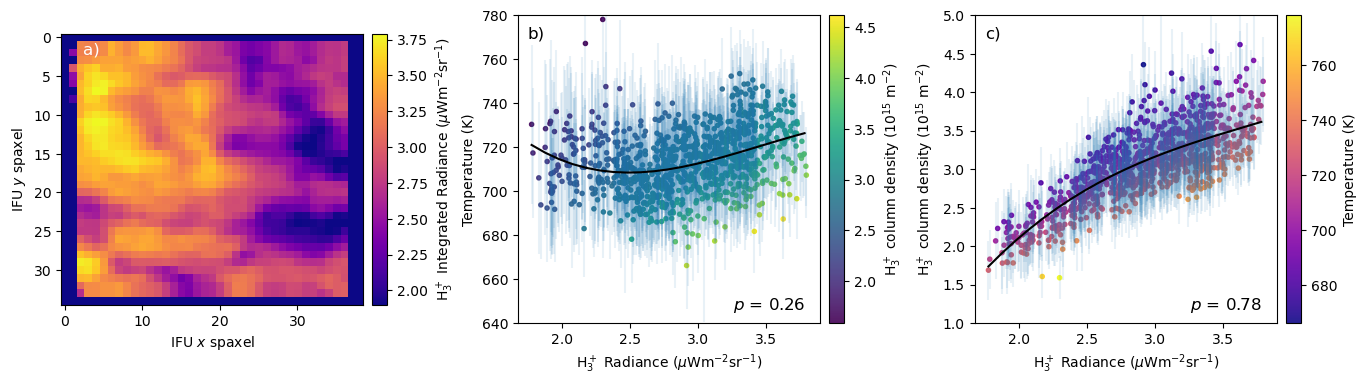

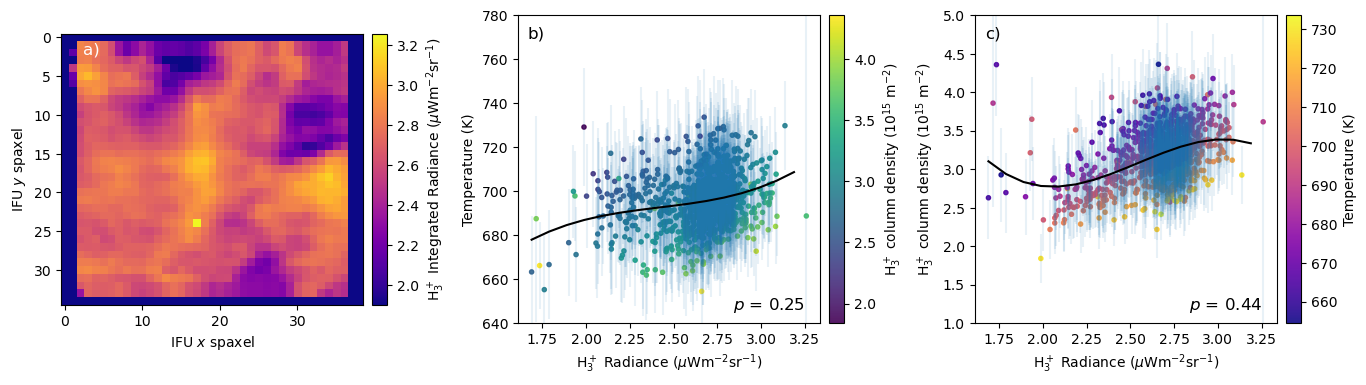

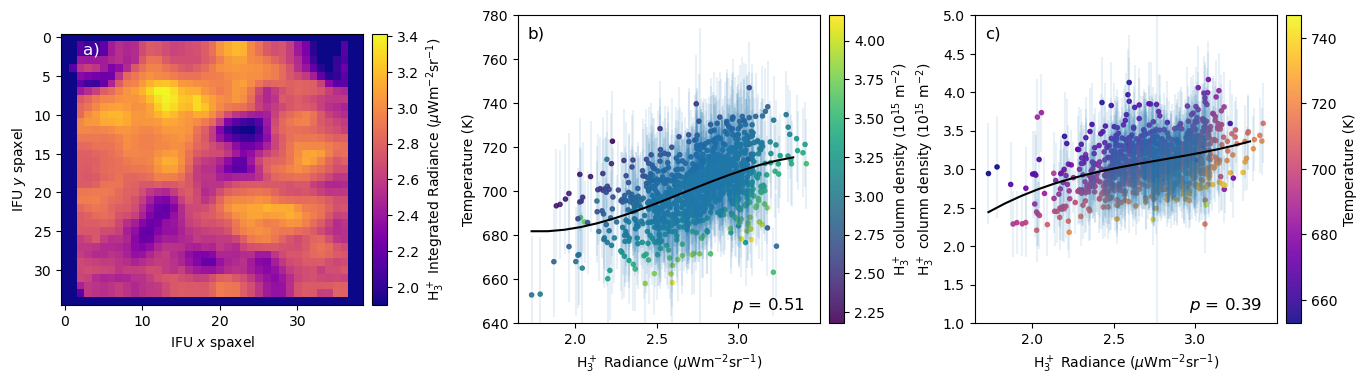

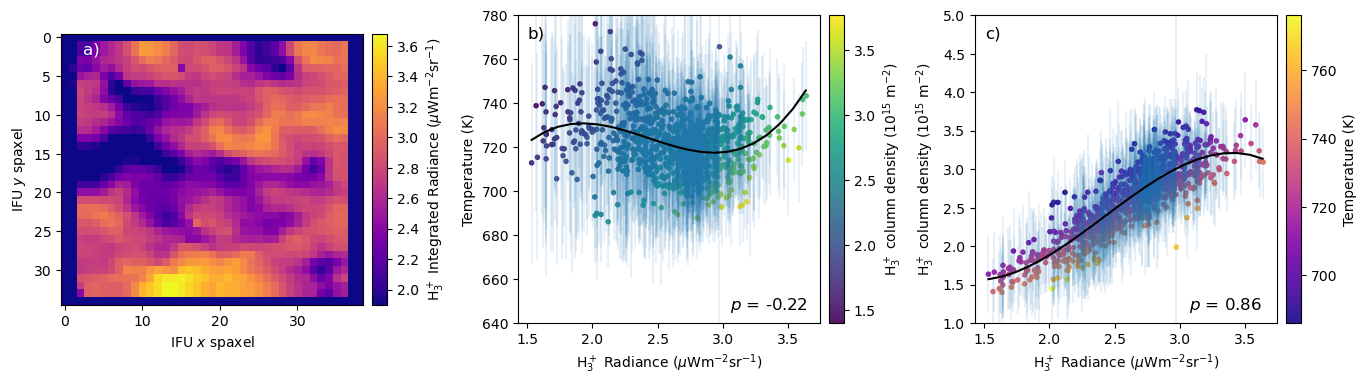

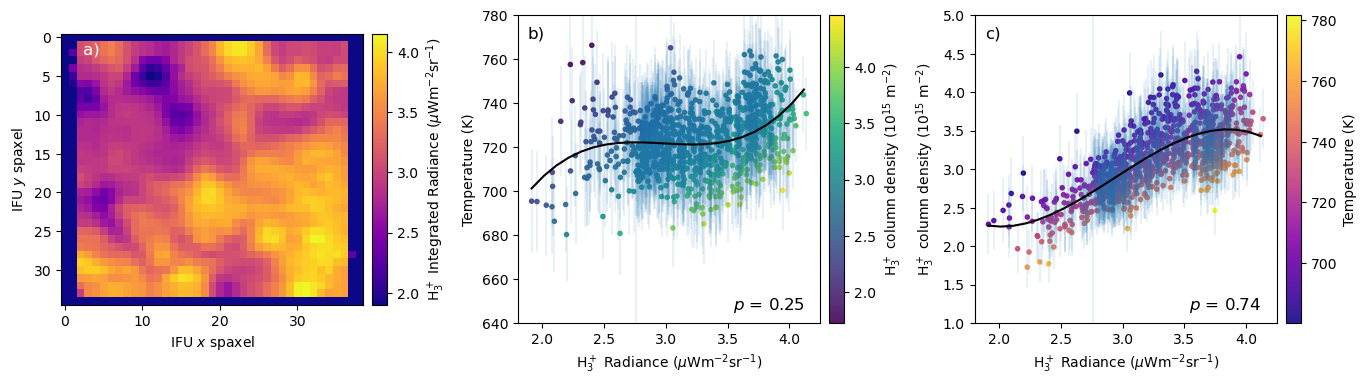

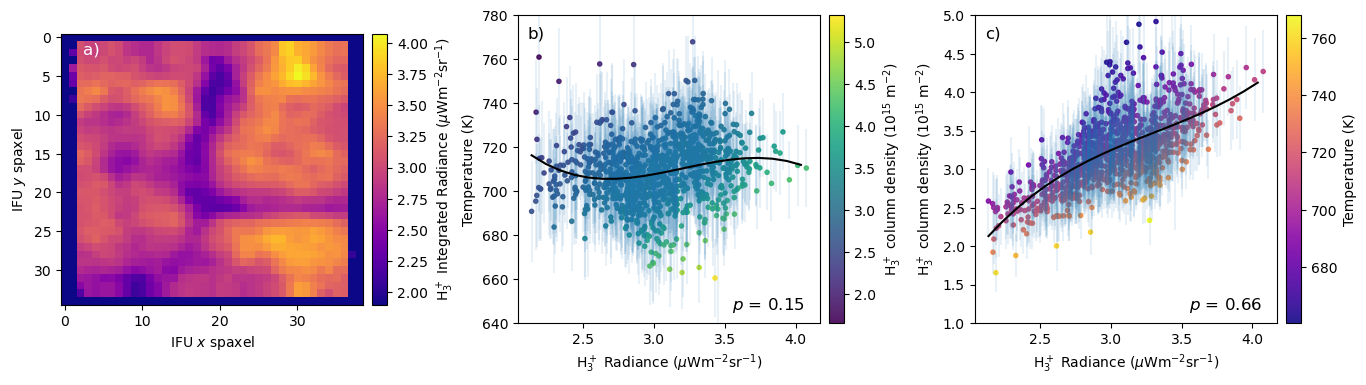

In [24]:

for nn in range(6) : 
    em = mask(emisss[nn]).flatten() * 1e6
    em = mask(ims[nn] * dwave * 1e6).flatten()

    ts = mask(temps[nn]).flatten()
    ds = mask(dens[nn]).flatten() / 1e15

    dts = mask(dtemps[nn]).flatten()
    dds = mask(ddens[nn]).flatten() / 1e15


    wht = np.argwhere((ts > 600) & (ts != 0))[:, 0]
    em = em[wht]
    ts = ts[wht]
    ds = ds[wht]
    dts = dts[wht]
    dds = dds[wht]

    print('number of decenet fits', ts.shape)

    fig, (ax3, ax1, ax2) = plt.subplots(1, 3, figsize = (16, 4))
    fig.subplots_adjust(wspace = 0.4)
    label_cd = 'H$_3^+$ column density (10$^{15}$ m$^{-2}$)'
    label_t = 'Temperature (K)'
    label_em = 'H$_3^+$ Radiance ($\mu$Wm$^{-2}$sr$^{-1}$)'

 
    fimp = ax1.scatter(em, ts, c=ds, cmap='viridis', marker = '.', alpha = 0.9)
    ax1.errorbar(em, ts, yerr = dts, ls = 'none', marker = 'none', alpha = 0.1)

    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.09)
    fig.colorbar(fimp, cax=cax, label = label_cd)
    ax1.set(xlabel = label_em, ylabel = label_t)

    ax1.set(ylim = (640, 780))

    nterms = 3
    fvars = np.polyfit(em, ts, nterms)
    fn = np.poly1d(fvars)
    eks = np.arange(np.min(em), np.max(em), 0.1)
    why = fn(eks)
    ax1.plot(eks, why, color='black')
    #ax1.fill_between(eks, why + np.median(dts), why - np.median(dts), facecolor='grey', alpha = 0.3)

    fimp2 = ax2.scatter(em, ds, c=ts, cmap='plasma', marker = '.', alpha = 0.9)
    ax2.errorbar(em, ds, yerr = dds, ls = 'none', marker = 'none', alpha = 0.1)
    ax2.set(ylim = (1, 5))

    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.09)
    fig.colorbar(fimp2, cax=cax, label = label_t)
    ax2.set(xlabel = label_em, ylabel = label_cd)

    fvars = np.polyfit(em, ds, nterms)
    fn = np.poly1d(fvars)
    eks = np.arange(np.min(em), np.max(em), 0.1)
    why = fn(eks)
    ax2.plot(eks, why, color='black')
    #ax2.fill_between(eks, why + np.median(dds), why - np.median(dds), facecolor='grey', alpha = 0.3)


    corr1 = sp.stats.pearsonr(em, ts)
    corr2 = sp.stats.pearsonr(em, ds)
    print(corr1.statistic, corr2.statistic)

    ax1.text(0.83, 0.06, "$p$ = {:.2f}".format(corr1.statistic), transform = ax1.transAxes, fontsize = 12, ha = 'center', va = 'center')
    ax2.text(0.83, 0.06, "$p$ = {:.2f}".format(corr2.statistic), transform = ax2.transAxes, fontsize = 12, ha = 'center', va = 'center')

    ax3.text(0.1, 0.94, 'a)', transform = ax3.transAxes, fontsize = 12, ha = 'center', va = 'center', color='white')
    ax1.text(0.06, 0.94, 'b)', transform = ax1.transAxes, fontsize = 12, ha = 'center', va = 'center')
    ax2.text(0.06, 0.94, 'c)', transform = ax2.transAxes, fontsize = 12, ha = 'center', va = 'center')


    #fig, ax = plt.subplots()
    hmap3 = ims[nn] * dwave * 1e6
    imh = ax3.imshow(hmap3, cmap='plasma', vmin=1.9)
    ax3.set(xlabel = 'IFU $x$ spaxel', ylabel = 'IFU $y$ spaxel')
    divider = make_axes_locatable(ax3)
    cax = divider.append_axes("right", size="5%", pad=0.09)
    fig.colorbar(imh, cax=cax, label = 'H$_3^+$ Integrated Radiance ($\mu$Wm$^{-2}$sr$^{-1}$)')
    #plt.savefig('figures/ERS_GRS_tile6_raw.pdf', bbox_inches = 'tight')
    plt.savefig('figures/ERS_GRS_tcd_correlation_tile' + str(nn+1) + '.pdf', bbox_inches = 'tight')

    fits.writeto('figures/jupiter_grs_h3p/figure5a.fits', hmap3 * 1e6, overwrite=True)
    fits.writeto('figures/jupiter_grs_h3p/figure5b.fits', np.array([em, ts, dts]), overwrite=True)
    fits.writeto('figures/jupiter_grs_h3p/figure5c.fits', np.array([em, ds, dds]), overwrite=True)



['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
number of decenet fits (957,)
0.25539136079186026 0.7826675380382748
number of decenet fits (957,)
0.24515605679181882 0.4430105232786004
number of decenet fits (957,)
0.5098955557643974 0.3899776379224318
number of decenet fits (957,)
-0.22432646210260287 0.8636544842261145
number of decenet fits (957,)
0.24980670282874654 0.7425234820387113


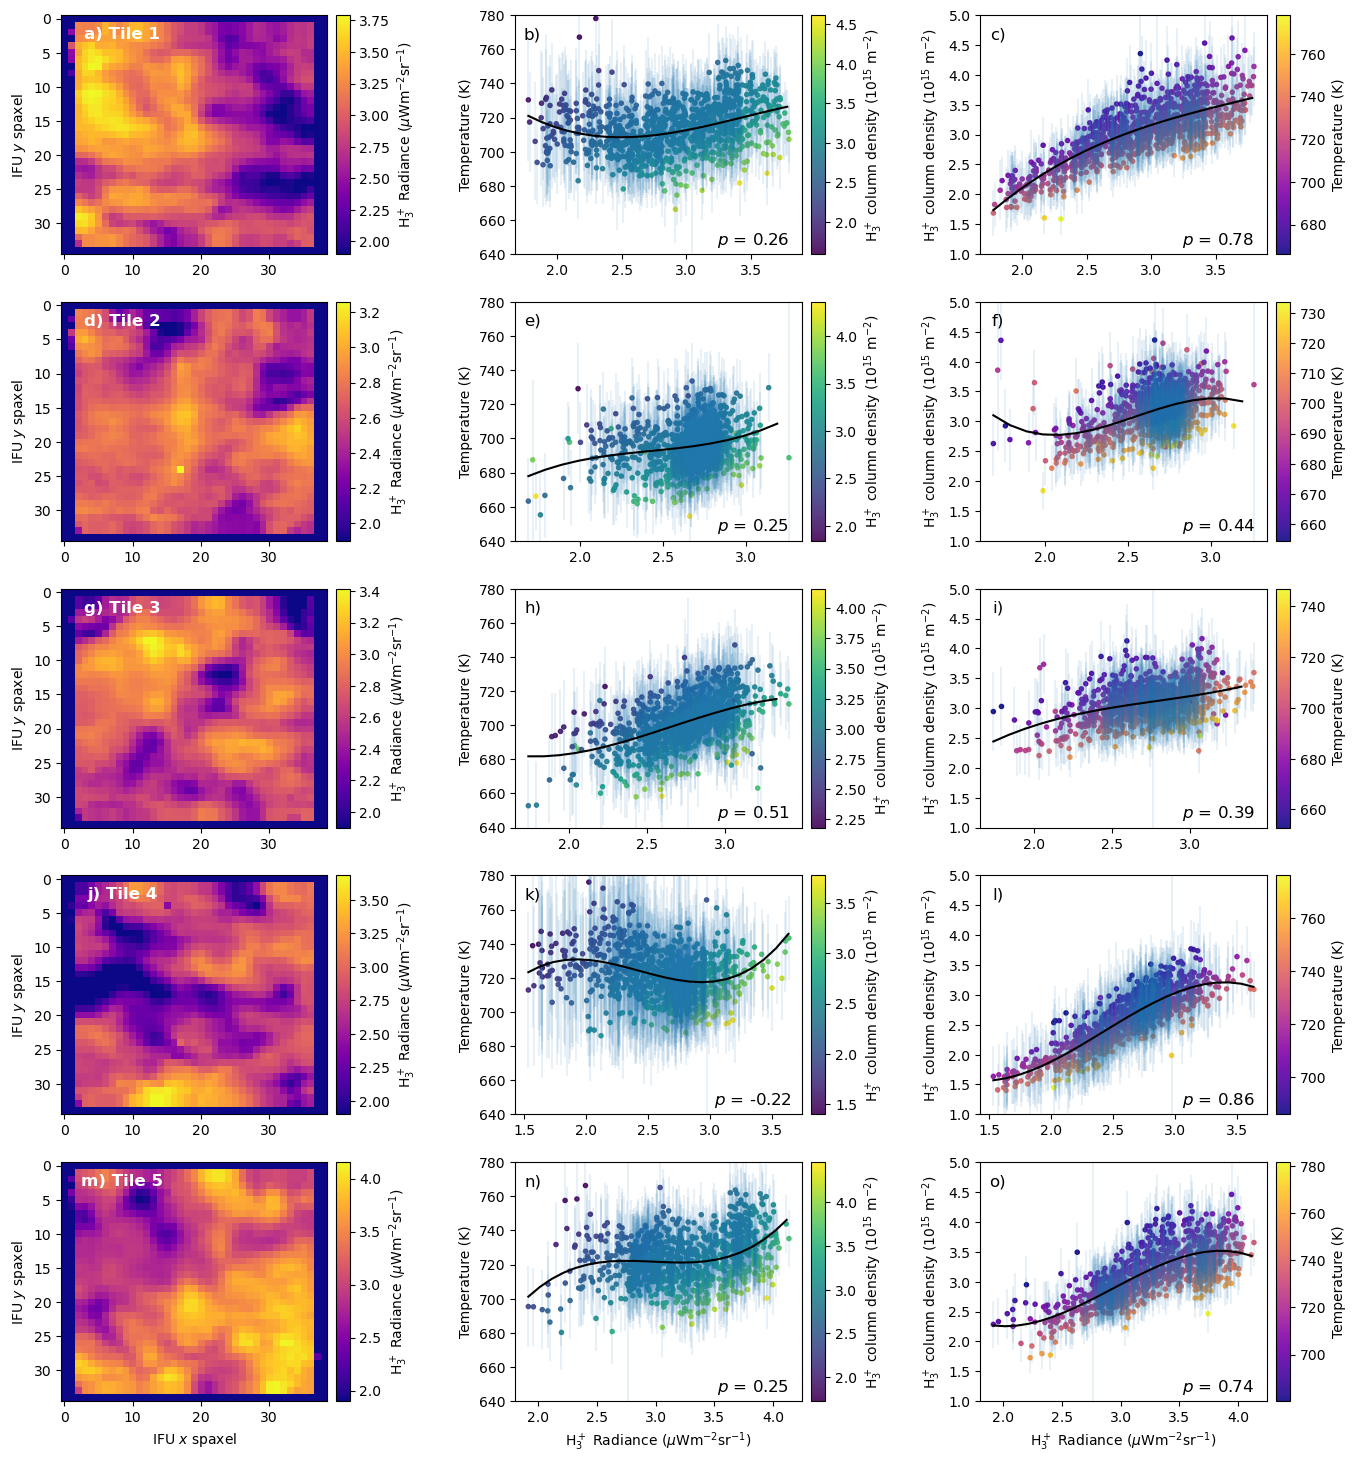

In [26]:
fig, axs = plt.subplots(5, 3, figsize = (16, 18))
fig.subplots_adjust(wspace = 0.5, hspace = 0.2)
labs = list('abcdefghijklmnopqrstuvwxyz')
print(labs)
lnbr = 0
for nn in range(5) : 
    em = mask(emisss[nn]).flatten() * 1e6
    em = mask(ims[nn] * dwave * 1e6).flatten()

    ts = mask(temps[nn]).flatten()
    ds = mask(dens[nn]).flatten() / 1e15

    dts = mask(dtemps[nn]).flatten()
    dds = mask(ddens[nn]).flatten() / 1e15

    ax3, ax1, ax2 = axs[nn]

    wht = np.argwhere((ts > 600) & (ts != 0))[:, 0]
    em = em[wht]
    ts = ts[wht]
    ds = ds[wht]
    dts = dts[wht]
    dds = dds[wht]

    print('number of decenet fits', ts.shape)



    label_cd = 'H$_3^+$ column density (10$^{15}$ m$^{-2}$)'
    label_t = 'Temperature (K)'
    label_em = 'H$_3^+$ Radiance ($\mu$Wm$^{-2}$sr$^{-1}$)'

 
     
    fimp = ax1.scatter(em, ts, c=ds, cmap='viridis', marker = '.', alpha = 0.9)
    ax1.errorbar(em, ts, yerr = dts, ls = 'none', marker = 'none', alpha = 0.1)
    
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.09)
    fig.colorbar(fimp, cax=cax, label = label_cd)
    if (nn == 4) : ax1.set(xlabel = label_em, ylabel = label_t)
    else : ax1.set(ylabel = label_t)
    nterms = 3
    fvars = np.polyfit(em, ts, nterms)
    fn = np.poly1d(fvars)
    eks = np.arange(np.min(em), np.max(em), 0.1)
    why = fn(eks)
    ax1.plot(eks, why, color='black')
#    ax1.fill_between(eks, why + np.median(dts), why - np.median(dts), facecolor='grey', alpha = 0.3)

    ax1.set(ylim = (640, 780))


    fimp2 = ax2.scatter(em, ds, c=ts, cmap='plasma', marker = '.', alpha = 0.9)
    ax2.errorbar(em, ds, yerr = dds, ls = 'none', marker = 'none', alpha = 0.1)
    ax2.set(ylim = (1, 5))


    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.09)
    fig.colorbar(fimp2, cax=cax, label = label_t)
    if (nn == 4) : ax2.set(xlabel = label_em, ylabel = label_cd)
    else : ax2.set(ylabel = label_cd)

    fvars = np.polyfit(em, ds, nterms)
    fn = np.poly1d(fvars)
    eks = np.arange(np.min(em), np.max(em), 0.1)
    why = fn(eks)
    ax2.plot(eks, why, color='black')
 #   ax2.fill_between(eks, why + np.median(dds), why - np.median(dds), facecolor='grey', alpha = 0.3)


    corr1 = sp.stats.pearsonr(em, ts)
    corr2 = sp.stats.pearsonr(em, ds)
    print(corr1.statistic, corr2.statistic)

    ax1.text(0.83, 0.06, "$p$ = {:.2f}".format(corr1.statistic), transform = ax1.transAxes, fontsize = 12, ha = 'center', va = 'center')
    ax2.text(0.83, 0.06, "$p$ = {:.2f}".format(corr2.statistic), transform = ax2.transAxes, fontsize = 12, ha = 'center', va = 'center')



    ax3.text(0.23, 0.92, labs[lnbr] + ') Tile ' + str(nn+1), transform = ax3.transAxes, fontsize = 12, ha = 'center', va = 'center', color='white', weight = 'bold')
    ax1.text(0.06, 0.92, labs[lnbr + 1] + ')', transform = ax1.transAxes, fontsize = 12, ha = 'center', va = 'center', weight = 'normal')
    ax2.text(0.06, 0.92, labs[lnbr + 2] + ')', transform = ax2.transAxes, fontsize = 12, ha = 'center', va = 'center', weight = 'normal')

    lnbr += 3

    #fig, ax = plt.subplots()
    hmap3 = ims[nn] * dwave * 1e6
    imh = ax3.imshow(hmap3, cmap='plasma', vmin=1.9)
    if (nn == 4) : ax3.set(xlabel = 'IFU $x$ spaxel', ylabel = 'IFU $y$ spaxel')
    else : ax3.set(ylabel = 'IFU $y$ spaxel')
    divider = make_axes_locatable(ax3)
    cax = divider.append_axes("right", size="5%", pad=0.09)
    fig.colorbar(imh, cax=cax, label = 'H$_3^+$ Radiance ($\mu$Wm$^{-2}$sr$^{-1}$)')
    #plt.savefig('figures/ERS_GRS_tile6_raw.pdf', bbox_inches = 'tight')
#    plt.savefig('figures/ERS_GRS_tcd_correlation_tile' + str(nn+1) + '.pdf', bbox_inches = 'tight')
plt.savefig('figures/ERS_GRS_tcd_correlation_1_5.pdf', bbox_inches = 'tight')

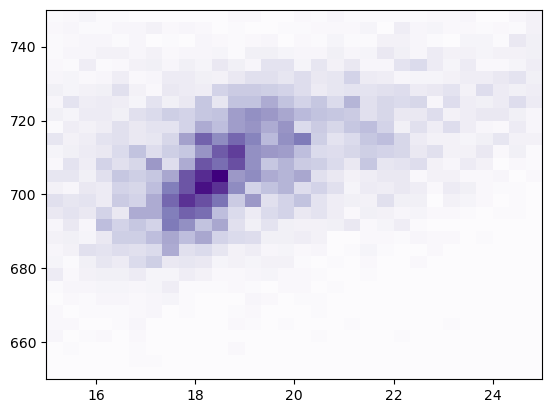

In [27]:
sdens = np.array(dens).flatten()
stemp = np.array(temps).flatten()
semiss = np.array(emisss).flatten()
fig, ax = plt.subplots()

hist, xbins, ybins = np.histogram2d(semiss * 1e6, stemp, bins=30, range=[[15, 25], [650, 750]], density = False)

#ax2 = ax.twinx()
#ax2.plot(semiss * 1e6)
#ax2.scatter(semiss*1e6, stemp, marker = marker, color='orange', alpha = 0.5)
#ax.imshow(hist)
ax.pcolormesh(xbins, ybins,  hist.T, cmap = 'Purples')
#ax.scatter(semiss*1e6, stemp, marker = marker, alpha = 0.1, color='white')

#ax.set(ylim = (600, 800), xlim = (0, 40))
#ax.set(ylim=[0, 0.6e16], xlim = (0, 40))

In [28]:
l2dir = '/Volumes/datar/jwst_data/nirspec_inspect/level2/'
l2files = sorted(glob.glob(l2dir + '*.fits'))
geo = jssp.JWSTSolarSystemPointing(l2files[3])
wave = geo.get_wavelength()
spec = geo.im[:, 15, 15]

whw = np.argwhere((wave > 3.4) & (wave < 3.458))


specu = geo.convert(wave, spec) * 1e4

h3p = h3ppy.h3p()
h3p.set(density = 1e16, temperature = 600, R = 2700, wavelength = wave[whw].flatten())
m = h3p.model()


fig, ax = plt.subplots()
ax.plot(wave[whw], specu[whw])
ax.plot(wave[whw], m)

IndexError: list index out of range

In [29]:

jm.Internal.Config(Model="jrm33", CartesianIn=False, CartesianOut=False)

res = 0.25

# Global grid
mxgrid = np.arange(260, 330, res)
mygrid = np.arange(-45, 5, res)

#res = 1.0
#mxgrid = np.arange(200, 360, res)
#mygrid = np.arange(-60, 20, res)


mout = np.zeros((mygrid.shape[0], mxgrid.shape[0]))
dip  = np.zeros((mygrid.shape[0], mxgrid.shape[0]))
for x in range(mxgrid.shape[0]) : 
    for y in range(mygrid.shape[0]) : 
        # Convert latitude to colatitude
        theta      = np.deg2rad((90 - mygrid[y]))
        phi        = np.deg2rad(360 - mxgrid[x])
        out        = jm.Internal.Field(1.0, theta, phi)
        mout[y, x] = np.abs(np.sum(out)) #[2] # np.sum(out)
        dip[y, x]  = np.arctan(out[0] / np.sqrt(out[1]**2 + out[2]**2))

691.0251773656032 730.9220264357537


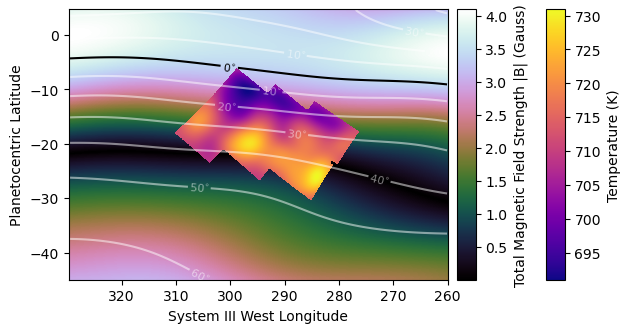

In [30]:
nbr = 0

# fig, (ax, ax1, ax2) = plt.subplots(1, 3, gridspec_kw={"width_ratios":[1, 0.08, 0.08]}) #, figsize = (12, 8))
fig, ax = plt.subplots()


ex = [np.min(mxgrid), np.max(mxgrid), np.max(mygrid), np.min(mygrid)]

#ang = ax.imshow(np.rad2deg(dip), aspect = 'equal', extent = ex, cmap='rainbow')
ang = ax.imshow(mout * 1e-5, aspect = 'equal', extent = ex, cmap='cubehelix', origin = 'upper')

ex2 = [np.min(xgrid), np.max(xgrid), np.max(ygrid), np.min(ygrid)]
him = ax.imshow(tmap, aspect = 'equal', extent = ex2, cmap='plasma', vmin=600, vmax=750)

CS = ax.contour(np.rad2deg(dip), levels=[0], colors='black', extent = ex, origin='upper', label = 'Dip Equator')
ax.clabel(CS, CS.levels, inline=True, fmt='%1.0f$^{\circ}$', fontsize=8, use_clabeltext=False, inline_spacing = 5)

CS2 = ax.contour(np.abs(np.rad2deg(dip)), levels=np.arange(-70, 70, 10), colors='white', extent = ex, origin='upper', label = 'Dip Equator', alpha = 0.5)
ax.clabel(CS2, CS2.levels, inline=True, fmt='%1.0f$^{\circ}$', fontsize=8, use_clabeltext=False, inline_spacing = 5)
#for geo in geos :     
#    ra = geo[1, :, :] #- l2geos[nbr].ra_target
#    dec = geo[0, :, :] # - l2geos[nbr].dec_target
#    ra_box = [ra[2, 2], ra[31, 2], ra[31, 35], ra[2, 35], ra[2, 2]]
#    dec_box = [dec[2, 2], dec[31, 2], dec[31, 35], dec[2, 35], dec[2, 2]]
#    time = l2geos[nbr].obs_start.replace('2022-07-27T', '')
#    ax.plot(ra_box, dec_box, label = str(nbr + 1) + '. ' + time[0:8], color='white') 
#    ax.text(np.mean(ra), np.mean(dec), str(nbr + 1) + '', color='white', horizontalalignment = 'center', verticalalignment = 'center')
#    nbr += 1

ax.set(xlim = (np.max(mxgrid), np.min(mxgrid)))
ax.set(ylim = (np.min(mygrid), np.max(mygrid)))
ax.set(xlabel = 'System III West Longitude', ylabel = 'Planetocentric Latitude') #, title = 'Connerney et al., (2022) JRM33 Model')


#CS3 = ax.contour(smooth(tmap, sm=30), levels=np.arange(690, 730, 10), extent = ex2, origin='upper', colors='black', alpha = 0.5)
#ax.clabel(CS3, CS3.levels, inline=True, fmt='%1.0f K', fontsize=6, use_clabeltext=True, inline_spacing = 5)
him = ax.imshow(smooth(tmap, sm=30), extent = ex2, origin = 'upper', cmap='plasma')


divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.09)
cax2 = divider.append_axes("right", size="5%", pad=0.7)
plt.colorbar(ang, cax=cax, label = 'Total Magnetic Field Strength |B| (Gauss)')
plt.colorbar(him, cax=cax2, label = 'Temperature (K)')


plt.savefig('figures/ERS_GRS_magnetic_field.pdf', bbox_inches = 'tight')
plt.show()

15.405950300714043 23.82856287885148


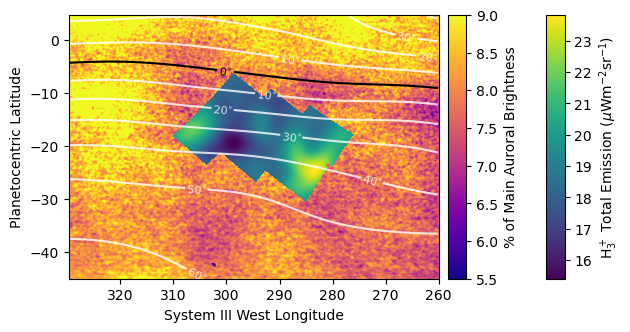

In [31]:
ex = [np.min(mxgrid), np.max(mxgrid), np.max(mygrid), np.min(mygrid)]


tssim = fits.getdata('data/tss_worm2.fits')
#tssim = tssim/np.max(tssim)

fig, ax = plt.subplots()
tim = ax.imshow(tssim*1000, extent=(360, 0, -90, 90), cmap = 'plasma', vmax=0.009*1000, vmin=0.0055*1000)
#ax.set(xlim=(np.max(mxgrid), np.min(mxgrid)), ylim = (np.min(mygrid), np.max(mygrid)))
ax.set(xlim=(np.max(mxgrid), np.min(mxgrid)), ylim = (np.min(mygrid), np.max(mygrid)))

ax.set(xlabel = 'System III West Longitude', ylabel = 'Planetocentric Latitude')
nbr = 0
for geo in geos : 
    ra = geo[1, :, :] #- l2geos[nbr].ra_target
    dec = geo[0, :, :] # - l2geos[nbr].dec_target
    ra_box = [ra[2, 2], ra[31, 2], ra[31, 35], ra[2, 35], ra[2, 2]]
    dec_box = [dec[2, 2], dec[31, 2], dec[31, 35], dec[2, 35], dec[2, 2]]
    time = l2geos[nbr].obs_start.replace('2022-07-27T', '')
    #ax.plot(ra_box, dec_box, label = str(nbr + 1) + '. ' + time[0:8], color='white') 
    #ax.text(np.mean(ra), np.mean(dec), str(nbr + 1) + '', color='white', horizontalalignment = 'center', verticalalignment = 'center')
    nbr += 1

CS = ax.contour(np.rad2deg(dip), levels=[0], colors='black', extent = ex, origin='upper', label = 'Dip Equator')
ax.clabel(CS, CS.levels, inline=True, fmt='%1.0f$^{\circ}$', fontsize=8, use_clabeltext=False, inline_spacing = 5)

CS2 = ax.contour(np.abs(np.rad2deg(dip)), levels=np.arange(-70, 70, 10), colors='white', extent = ex, origin='upper', label = 'Dip Equator', alpha = 0.8)
ax.clabel(CS2, CS2.levels, inline=True, fmt='%1.0f$^{\circ}$', fontsize=8, use_clabeltext=False, inline_spacing = 5)
ex = [np.min(xgrid), np.max(xgrid), np.max(ygrid), np.min(ygrid)]

him = ax.imshow(smooth(totemiss * 1e6, sm=30), aspect = 'equal', extent = ex, cmap='viridis')
#him = ax.imshow(smooth(tmap, sm=30), aspect = 'equal', extent = ex2, cmap='gist_heat')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.09)
cax2 = divider.append_axes("right", size="5%", pad=0.8)
plt.colorbar(tim, cax=cax, label = '% of Main Auroral Brightness')
plt.colorbar(him, cax=cax2, label = 'H$_3^+$ Total Emission ($\mu$Wm$^{-2}$sr$^{-1}$)')

plt.savefig('figures/ERS_GRS_tss_worm.pdf', bbox_inches = 'tight')


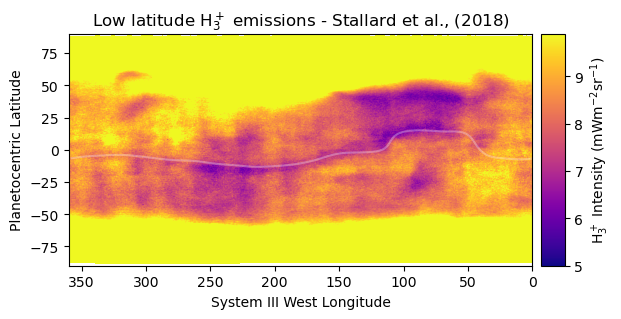

In [32]:

jm.Internal.Config(Model="jrm33", CartesianIn=False, CartesianOut=False)

res = 1

# Global grid
mxgrid = np.arange(0, 360, res)
mygrid = np.arange(-90, 90, res)

mout2 = np.zeros((mygrid.shape[0], mxgrid.shape[0]))
dip2  = np.zeros((mygrid.shape[0], mxgrid.shape[0]))
for x in range(mxgrid.shape[0]) : 
    for y in range(mygrid.shape[0]) : 
        # Convert latitude to colatitude
        theta      = np.deg2rad((90 - mygrid[y]))
        phi        = np.deg2rad(360 - mxgrid[x])
        out        = jm.Internal.Field(1.0, theta, phi)
        mout2[y, x] = np.abs(np.sum(out)) #[2] # np.sum(out)
        dip2[y, x]  = np.arctan(out[0] / np.sqrt(out[1]**2 + out[2]**2))

ex = [np.min(mxgrid), np.max(mxgrid), np.max(mygrid), np.min(mygrid)]


tssim = fits.getdata('data/tss_worm2.fits')
fig, ax = plt.subplots()
intmap = ax.imshow(tssim * 1e3, extent=(360, 0, -90, 90), cmap = 'plasma', vmax=0.0099*1e3, vmin=0.005*1e3)
#ax.set(xlim=(np.max(mxgrid), np.min(mxgrid)), ylim = (np.min(mygrid), np.max(mygrid)))
ax.set(xlim=(360, 0), ylim = (-90, 90))

ax.set(xlabel = 'System III West Longitude', ylabel = 'Planetocentric Latitude')
if False : 
    nbr = 0
    for geo in geos : 
        ra = geo[1, :, :] #- l2geos[nbr].ra_target
        dec = geo[0, :, :] # - l2geos[nbr].dec_target
        ra_box = [ra[2, 2], ra[31, 2], ra[31, 35], ra[2, 35], ra[2, 2]]
        dec_box = [dec[2, 2], dec[31, 2], dec[31, 35], dec[2, 35], dec[2, 2]]
        time = l2geos[nbr].obs_start.replace('2022-07-27T', '')
        #ax.plot(ra_box, dec_box, label = str(nbr + 1) + '. ' + time[0:8], color='white') 
        #ax.text(np.mean(ra), np.mean(dec), str(nbr + 1) + '', color='white', horizontalalignment = 'center', verticalalignment = 'center')
        nbr += 1
ls = ['dotted', 'solid', 'dotted']
ax.contour(np.rad2deg(dip2), levels=[0], colors='white', extent = ex, origin='upper', alpha = 0.3)
#fig.legend()
ex = [np.min(xgrid), np.max(xgrid), np.max(ygrid), np.min(ygrid)]
#ax.imshow(hmap, aspect = 'equal', extent = ex, cmap='plasma')
ax.set(title = 'Low latitude H$_3^+$ emissions - Stallard et al., (2018)')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.09)
fig.colorbar(intmap, cax=cax, label = r'H$_3^+$ Intensity (mWm$^{-2}$sr$^{-1}$)')
plt.savefig('figures/ERS_GRS_tss_full_worm.pdf',  bbox_inches='tight')

In [11]:
def asSpherical(x, y, z):
    #takes list xyz (single coord)
    r       =  np.sqrt(x*x + y*y + z*z)
    theta   =  np.arccos(z/r)#*180/ pi #to degrees
    phi     =  np.arctan2(y,x)#*180/ pi
    return r,theta,phi

def asCartesian(r, theta, phi):
    #takes list rthetaphi (single coord)
    x = r * np.sin( theta ) * np.cos( phi )
    y = r * np.sin( theta ) * np.sin( phi )
    z = r * np.cos( theta )
    return x,y,z
    
jm.Internal.Config(Model="jrm33", CartesianIn=False, CartesianOut=False)

res = 0.25

# Global grid
mxgrid = np.arange(260, 330, res)

mygrid = np.arange(-20, 10, res)
mzgrid = np.arange(1.0, 1.0 + 3 * 1000.0 / 71492.0, 0.001)

#res = 1.0
#mxgrid = np.arange(200, 360, res)
#mygrid = np.arange(-60, 20, res)

mlon = 295.0
mout = np.zeros((mzgrid.shape[0], mygrid.shape[0]))
dip  = np.zeros((mzgrid.shape[0], mygrid.shape[0]))
for x in range(mzgrid.shape[0]) : 
    for y in range(mygrid.shape[0]) : 
        # Convert latitude to colatitude
        theta      = np.deg2rad((90 - mygrid[y]))
        phi        = np.deg2rad(360 - mlon)
        out        = jm.Internal.Field(mzgrid[x], theta, phi)
        mout[x, y] = np.abs(np.sum(out)) #[2] # np.sum(out)
        dip[x, y]  = np.arctan(out[0] / np.sqrt(out[1]**2 + out[2]**2))

jm.Con2020.Config(equation_type='analytic')
r = np.arange(1.0 , 1.5, 1000.0 / 71492.0 * 1)

1000.0 / 71492.0

# Run the altitude points up from 0 latitude
theta = np.deg2rad(np.repeat(90, r.shape[0]))
phi = np.deg2rad(np.repeat(360 - 300, r.shape[0]))
x, y, z = asCartesian(r, theta, phi)
#create trace objects, pass starting position(s) x0,y0,z0
T0 = jm.TraceField(x, y ,z ,Verbose=True,IntModel='jrm33', ExtModel='none', MaxLen = 100000, MaxStep = 0.01)

        

Tracing field line 36 of 36 (100.00)%


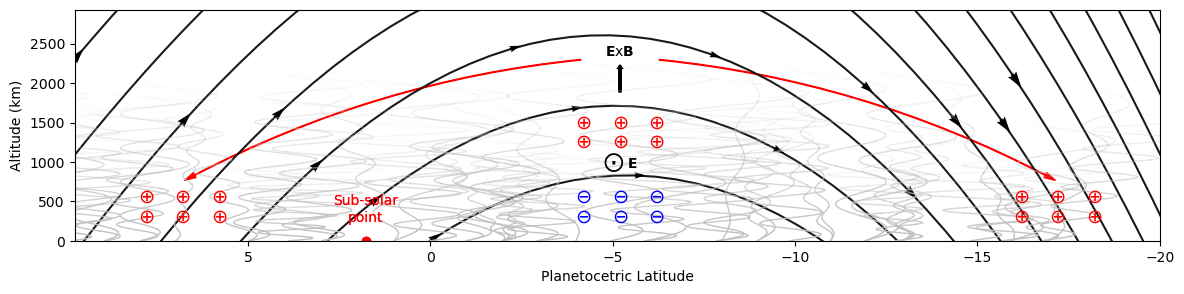

In [33]:
def wave_line(start, end, arr_size = 1, n = 5, col='gray', linew=1., width = 0.1, arr_yscale = 1):
    xmin, ymin = start
    xmax, ymax = end
    dist = np.sqrt((xmin - xmax)**2 + (ymin - ymax)**2)
    n0 = dist / (2 * np.pi)
    
    nn = 150
    x = np.linspace(0, dist, nn) + xmin
    width2 = np.linspace(width, width * 3, nn)
    y = width2 * np.sin(n * x / n0) + ymin
    for i in range(0, nn - 10, 10) : 
        line = plt.Line2D(x[i:(i+11)],y[i:(i+11)], color=col, lw=linew, alpha = 1 - (i / (150 - 10)))
        del_x = xmax - xmin
        del_y = ymax - ymin
        ang = np.arctan2(del_y, del_x)
        line.set_transform(mpl.transforms.Affine2D().rotate_around(xmin, ymin, ang) + ax.transData)
        ax.add_line(line)

fig, ax = plt.subplots(figsize = (14, 3))

mzgrid2 = mzgrid.copy() - 1.0
mzgrid2 *= 71492.0
ex = [np.min(mygrid), np.max(mygrid), np.min(mzgrid2), np.max(mzgrid2)]

#immout = ax.imshow(mout * 1e-5, extent = ex, aspect = 'auto', origin = 'lower', cmap='viridis', alpha = 0.2)
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="2%", pad=0.09)
#plt.colorbar(immout, cax=cax, label = "Total Magnetic Field\nStrength |B| (Gauss)")

ax.set(xlim=(ex[1], ex[0]), ylim=(ex[2], ex[3]))
ax.set(xlabel = 'Planetocetric Latitude', ylabel = 'Altitude (km)')

for i, x in enumerate(theta) : 
    arr = [T0.x[i, :],  T0.y[i, :], T0.z[i, :]]
    r, theta2, phi = asSpherical(T0.x[i, :],  T0.y[i, :], T0.z[i, :])
    xx = 90 - np.rad2deg(theta2)
    yy = (r - 1.0)*71492.0
    ax.plot(xx, yy, color='black', alpha = 0.9)
#    ax.text(xx, (r[20] - 1.0)*71492.0, str(T0.Rmax[i]))
    for nn in np.arange(0, 100, 10) : 
        ax.quiver(xx[nn], yy[nn], (xx[nn] - xx[nn - 1]), (yy[nn] - yy[nn - 1]), scale_units='xy', angles='xy', scale=1.9)
    #nn = 5
    #ax.quiver(xx[nn], yy[nn], (xx[nn] - xx[nn + 1]), (yy[nn] - yy[nn + 1]), scale_units='xy', angles='xy', scale=1.5)
#ax.grid()
#ax.fill_betweenx(500, 1000, color='grey', alpha = 0.3)
ax.plot(np.repeat(l2geos[0].lat_sun, 2), [0, 3000], 'o', color='red')
#print(np.rad2deg(np.sin(np.deg2rad(1.91409))))
#ax.axvspan(-30, -6, color='grey', alpha = 0.3)
ax.text(l2geos[0].lat_sun, 400, "Sub-solar\npoint", ha = 'center', va = 'center', color='red', rotation = 0)

plt.savefig('figures/ERS_GRS_mag_lat_alt_part0.pdf', bbox_inches='tight')

xcen = -5.2
ax.text(xcen, 1000, r'$\bigodot$ ${\bf E}$', va = 'center', ha='center')

plt.savefig('figures/ERS_GRS_mag_lat_alt_part1.pdf', bbox_inches='tight')

ax.text(xcen, 2400, r'${\bf E}$x${\bf B}$', va = 'center', ha='center')
ax.arrow(xcen, 1900, 0, 300, linewidth = 2.5, head_length = 6, head_width = 0.02)
# \bigodot \bigotimes
plt.savefig('figures/ERS_GRS_mag_lat_alt_part2.pdf', bbox_inches='tight')

#x, y ,z = asCartesian(1.1, np.deg2rad(1.91409), np.deg2rad(0))
#print(x * 71492.0, y, z)
ax.plot(np.repeat(l2geos[0].lat_sun, 2), [0, 3000], 'o', color='red')
#print(np.rad2deg(np.sin(np.deg2rad(1.91409))))
#ax.axvspan(-30, -6, color='grey', alpha = 0.3)
ax.text(l2geos[0].lat_sun, 400, "Sub-solar\npoint", ha = 'center', va = 'center', color='red', rotation = 0)
yy = np.array([0, 0, 0, 250, 250, 250])
xx = np.array([-1, 0, 1, -1, 0, 1]) + xcen
yyn = yy + 1250
yyp = yy + 300

for i, x in np.ndenumerate(xx) : 
    ax.text(xx[i], yyp[i], r'$\ominus$', color='blue', ha = 'center', va='center', fontsize=14, weight='bold')
    ax.text(xx[i], yyn[i], r'$\oplus$', color='red', ha = 'center', va='center', fontsize=14, weight='bold')

plt.savefig('figures/ERS_GRS_mag_lat_alt_part3.pdf', bbox_inches='tight')

style = "Simple, tail_width=0.5, head_width=4, head_length=8"
kw = dict(arrowstyle=style, color="red")

#a1 = mpatches.FancyArrowPatch((-0.4, -0.6), (0, 0.6), **kw)
#a2 = mpatches.FancyArrowPatch((0, 0.6), (0.4, -0.6), **kw)
a1 = mpatches.FancyArrowPatch((xcen + 1, 2300), (xcen + 12, 750), connectionstyle="arc3,rad=.1", **kw)
ax.add_patch(a1)
a2 = mpatches.FancyArrowPatch((xcen - 1, 2300), (xcen - 12, 750), connectionstyle="arc3,rad=-.1", **kw)
ax.add_patch(a2)



yyn = yy + 300
xxn = xx + 12
for i, x in np.ndenumerate(xx) : 
#    ax.text(xx[i], yyp[i], r'$\ominus$', color='blue', ha = 'center', va='center', fontsize=14, weight='bold')
    ax.text(xxn[i], yyn[i], r'$\oplus$', color='red', ha = 'center', va='center', fontsize=14, weight='bold')

xxn = xx - 12
for i, x in np.ndenumerate(xx) : 
#    ax.text(xx[i], yyp[i], r'$\ominus$', color='blue', ha = 'center', va='center', fontsize=14, weight='bold')
    ax.text(xxn[i], yyn[i], r'$\oplus$', color='red', ha = 'center', va='center', fontsize=14, weight='bold')
plt.savefig('figures/ERS_GRS_mag_lat_alt_part4.pdf', bbox_inches='tight')

wavecol = 'silver'
for i in range(50) : 
    lat_start = np.random.randint(-22, 12)
    lat_end = lat_start + np.random.randint(-3, 3)
    width = float(np.random.randint(1, 8)) / 10.0
    n = np.random.randint(3, 8)
    altitude_end = np.random.randint(1000, 2500)
    wave_line((lat_start, 0), (lat_end, altitude_end), n=n, width = width, col=wavecol)

if False : 
    wave_line((0, 0), (-5, 2000), n=10, width = 1, col=wavecol)
    wave_line((5, 0), (7, 2500), n=10, width = 1, col=wavecol)
    wave_line((5, 0), (-2, 2500), n=10, width = 0.5, col=wavecol)
    wave_line((-10, 0), (-8, 2500), n=8, width = 0.6, col=wavecol)
    wave_line((-11, 0), (-13, 2500), n=5, width = 0.9, col=wavecol)
    wave_line((-11, 0), (-13, 2500), n=5, width = 0.9, col=wavecol)
    wave_line((-14, 0), (-17, 2000), n=12, width = 0.6, col=wavecol)
    wave_line((-16, 0), (-10, 2000), n=4, width = 0.6, col=wavecol)
    wave_line((-16, 0), (-16, 4000), n=8, width = 0.2, col=wavecol)
    wave_line((-18, 0), (-18, 2500), n=10, width = 0.2, col=wavecol)
    wave_line((-20, 0), (-15, 3500), n=10, width = 0.4, col=wavecol)

plt.savefig('figures/ERS_GRS_mag_lat_alt.pdf', bbox_inches='tight')


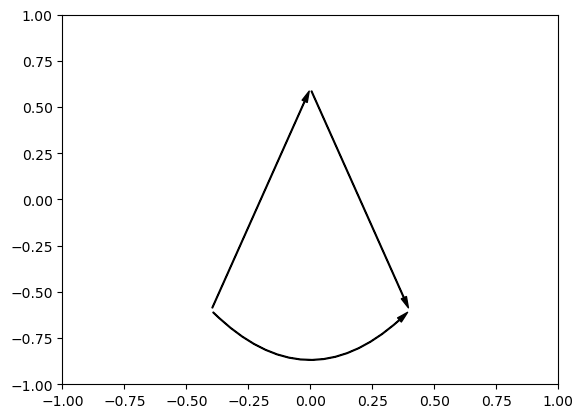

In [34]:
fig, ax = plt.subplots()

style = "Simple, tail_width=0.5, head_width=4, head_length=8"
kw = dict(arrowstyle=style, color="k")

a1 = mpatches.FancyArrowPatch((-0.4, -0.6), (0, 0.6), **kw)
a2 = mpatches.FancyArrowPatch((0, 0.6), (0.4, -0.6), **kw)
a3 = mpatches.FancyArrowPatch((-0.4, -0.6), (0.4, -0.6), connectionstyle="arc3,rad=.5", **kw)
ax.set(xlim=(-1, 1), ylim=(-1, 1))
for a in [a1, a2, a3]:
    ax.add_patch(a)
plt.show()

(6927,)


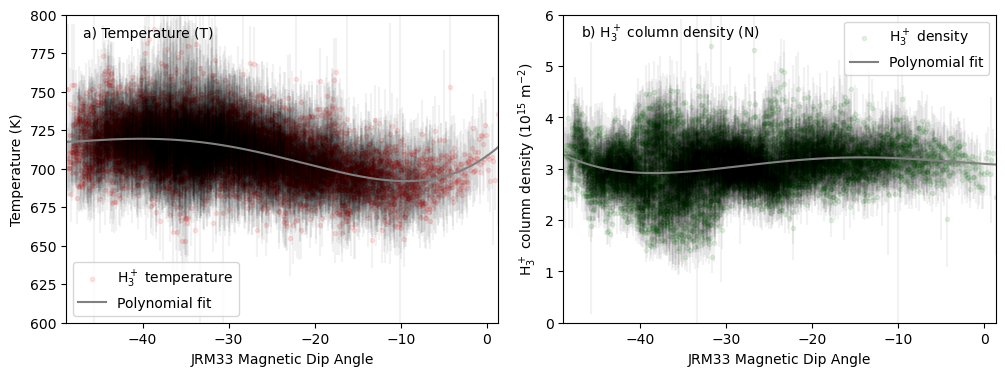

In [46]:

jm.Internal.Config(Model="jrm33", CartesianIn=False, CartesianOut=False)


ftemps = np.array(temps).flatten()
fdens = np.array(dens).flatten()
fdtemps = np.array(dtemps).flatten()
fddens = np.array(ddens).flatten()

#fdips = ftemps.copy()
fdips = []
flats = []
flons = []
for l in geos :
    lat = l[0, :, :].flatten()
    lon = l[1, :, :].flatten()
    for i, l in np.ndenumerate(lat) : 
        theta      = np.deg2rad(90 - lat[i])
        phi        = np.deg2rad(360 - lon[i])
        out        = jm.Internal.Field(1.0, theta, phi)
        #mout2[y, x] = np.abs(np.sum(out)) #[2] # np.sum(out)
        dip  = np.arctan(out[0] / np.sqrt(out[1]**2 + out[2]**2))
        fdips.append(np.rad2deg(dip))
        flats.append(lat)
        flons.append(lon)

flats = np.array(flats).flatten()
flons = np.array(flons).flatten()
fdips = np.array(fdips).flatten()

#xgrid = np.arange(275, 312, res)
#ygrid = np.arange(-32, -5, res)
wht = np.argwhere((ftemps > 600) & (ftemps < 800)).flatten()
flats = flats[wht]
ftemps = ftemps[wht]
fdtemps = fdtemps[wht]

fdens = fdens[wht]
fddens = fddens[wht]
fdips = fdips[wht]



print(wht.shape)
xr = [np.min(fdips), np.max(fdips)]

hist, xbins, ybins = np.histogram2d(fdips, ftemps, bins=30, range=[[xr[0], xr[1]], [650, 780]], density = False)
fp = np.polyfit(fdips, ftemps, 4)
ffn = np.poly1d(fp)
eks = np.arange(xr[0], xr[1], 0.1)
why = ffn(eks)


fig, (ax, ax2) = plt.subplots(1, 2, figsize= (12, 4))
fig.subplots_adjust(wspace = 0.15)
#ax.plot(fdips, ftemps, 'o', alpha = 0.1, mec='None', mfc = 'red', ms = 5, label = 'T fit')
ax.scatter(fdips, ftemps, color='red', marker = '.', alpha = 0.1, label = 'H$_3^+$ temperature')
ax.errorbar(fdips, ftemps, yerr = fdtemps, ls = 'none', marker = 'none', alpha = 0.05, ecolor = 'black')


#immout = ax.pcolormesh(xbins, ybins,  hist.T, cmap = 'Reds')
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.09)
#plt.colorbar(immout, cax=cax, label = "Number of IFU spaxels")
ax.plot(eks, why, color='grey', label = 'Polynomial fit')
#ax.fill_between(eks, why + np.median(dts), why - np.median(dts), facecolor='grey', alpha = 0.3, label = 'Median $\Delta$T')
ax.legend()
ax.set(xlabel = 'JRM33 Magnetic Dip Angle', ylabel = 'Temperature (K)')
ax.set(xlim = (xr[0], xr[1]), ylim = (600, 800))
#ax.plot(flats, ftemps, 'o')
#ax.set(ylim = [650, 800])

hist2, xbins2, ybins2 = np.histogram2d(fdips, fdens/1e15, bins=30, range=[[xr[0], xr[1]], [0, 6]], density = False)
fp = np.polyfit(fdips, fdens/1e15, 4)
ffn = np.poly1d(fp)
eks = np.arange(xr[0], xr[1], 0.1)
why = ffn(eks)


ax2.scatter(fdips, fdens / 1e15, color='green', marker = '.', alpha = 0.1, label = 'H$_3^+$ density')
ax2.errorbar(fdips, fdens / 1e15, yerr = fddens / 1e15, ls = 'none', marker = 'none', alpha = 0.05, ecolor = 'black')

#ax2.plot(fdips, fdens / 1e15, 'o', alpha = 0.1, mec='None', mfc = 'green', ms = 5, label = 'N fit')
immout22 = ax.pcolormesh(xbins2, ybins2,  hist2.T, cmap = 'Reds')
#divider = make_axes_locatable(ax2)
#cax = divider.append_axes("right", size="5%", pad=0.09)
#plt.colorbar(immout22, cax=cax, label = "Number of IFU spaxels")
ax2.plot(eks, why, color='grey', label = 'Polynomial fit')

#ax2.fill_between(eks, why + np.median(dds), why - np.median(dds), facecolor='grey', alpha = 0.3, label='Median $\Delta$N')

ax2.legend()
ax2.set(xlabel = 'JRM33 Magnetic Dip Angle', ylabel = 'H$_3^+$ column density (10$^{15}$ m$^{-2}$)')
ax2.set(xlim = (xr[0], xr[1]), ylim = (0, 6))
#ax.plot(flats, ftemps, 'o')
#ax.set(ylim = [650, 800])

ax.text(0.04, 0.94, 'a) Temperature (T)', transform = ax.transAxes, fontsize = 10, ha = 'left', va = 'center')
ax2.text(0.04, 0.94, 'b) H$_3^+$ column density (N)', transform = ax2.transAxes, fontsize = 10, ha = 'left', va = 'center')


plt.savefig('figures/ERS_GRS_params_dip_angle.pdf', bbox_inches = 'tight')


Tracing field line 9 of 9 (100.00)%


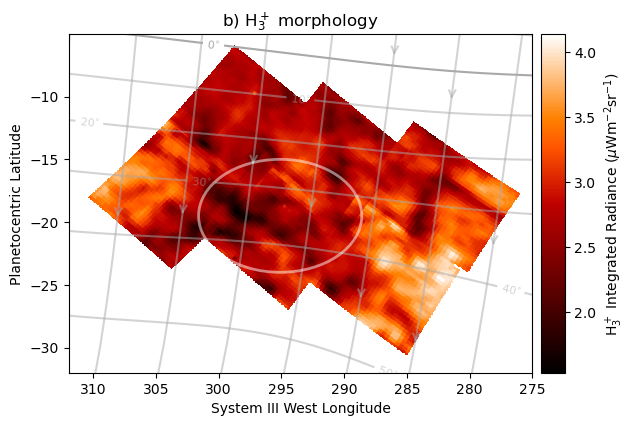

In [12]:
jm.Con2020.Config(equation_type='analytic')

1000.0 / 71492.0


res = 0.5

# Global grid
mxgrid = np.arange(270, 315, res)
mygrid = np.arange(-35, 5, res)

mout3 = np.zeros((mygrid.shape[0], mxgrid.shape[0]))
dip3  = np.zeros((mygrid.shape[0], mxgrid.shape[0]))
for x in range(mxgrid.shape[0]) : 
    for y in range(mygrid.shape[0]) : 
        # Convert latitude to colatitude
        theta      = np.deg2rad((90 - mygrid[y]))
        phi        = np.deg2rad(360 - mxgrid[x])
        out        = jm.Internal.Field(1.0, theta, phi)
        mout3[y, x] = np.abs(np.sum(out)) #[2] # np.sum(out)
        dip3[y, x]  = np.arctan(out[0] / np.sqrt(out[1]**2 + out[2]**2))


phi     = np.deg2rad(np.arange(360 - 315, 360 - 270, 5)) #np.deg2rad(np.repeat(360 - 300, r.shape[0]))
theta   = np.deg2rad(np.repeat(90+33, phi.shape[0]))
r       = np.repeat(1.0 + 500.0 / 71492.0, phi.shape[0]) #np.arange(1.0 , 1.5, 1000.0 / 71492.0 * 1)
x, y, z = asCartesian(r, theta, phi)
#create trace objects, pass starting position(s) x0,y0,z0
T0 = jm.TraceField(x, y , z, Verbose=True,IntModel='jrm33', ExtModel='none') #, MaxLen = 100000, MaxStep = 0.01)

dwave = wave[301] - wave[300]
fig, ax = plt.subplots() #, figsize = (12, 8))
ex = [np.min(xgrid), np.max(xgrid), np.max(ygrid), np.min(ygrid)]
imh3p = ax.imshow((hmap*dwave)*1e6, aspect = 'equal', extent = ex, cmap='gist_heat')
ax.set(xlim = (np.max(xgrid), np.min(xgrid)))
ax.set(ylim = (np.min(ygrid), np.max(ygrid)))
ax.set(xlabel = xlabel, ylabel = ylabel) #, title='H$_3^+$ intensity')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.09)
fig.colorbar(imh3p, cax=cax, label = 'H$_3^+$ Integrated Radiance ($\mu$Wm$^{-2}$sr$^{-1}$)')

ccol = 'darkgrey'

for i, x in enumerate(theta) : 
    arr = [T0.x[i, :],  T0.y[i, :], T0.z[i, :]]
    r2, theta2, phi2 = asSpherical(T0.x[i, :],  T0.y[i, :], T0.z[i, :])
    yy = 90 - np.rad2deg(theta2)
    xx = 360 - np.rad2deg(phi2)
    #yy = (r - 1.0)*71492.0
    #print(yy)
    ax.plot(xx, yy, color=ccol, alpha = 0.5, zorder=1)
    nn = 55
    for nn in np.arange(3, xx.shape[0], 5) : 
        #ax.quiver(xx[nn], yy[nn], (xx[nn] - xx[nn - 1]), (yy[nn] - yy[nn - 1]), scale_units='xy', angles='xy', scale=5, color=ccol)
        ax.plot([xx[nn] + 0.2, xx[nn]], [yy[nn] + 0.5, yy[nn]], color=ccol, alpha = 0.5, zorder = 1)
        ax.plot([xx[nn] - 0.3, xx[nn]], [yy[nn] + 0.5, yy[nn]], color=ccol, alpha = 0.5, zorder = 1)
#    ax.plot(360 - np.rad2deg(phi), 90-np.rad2deg(theta), '.', color='red')
    #print(360 - np.rad2deg(phi))

mex = [np.min(mxgrid), np.max(mxgrid), np.max(mygrid), np.min(mygrid)]
CS = ax.contour(np.rad2deg(dip3), levels=[0], colors=ccol, extent = mex, origin='upper', label = 'Dip Equator')
ax.clabel(CS, CS.levels, inline=True, fmt='%1.0f$^{\circ}$', fontsize=8, use_clabeltext=False, inline_spacing = 5)

CS2 = ax.contour(np.abs(np.rad2deg(dip3)), levels=np.arange(-70, 70, 10), colors=ccol, extent = mex, origin='upper', label = 'Dip Equator', alpha = 0.5, zorder = 1)
ax.clabel(CS2, CS2.levels, inline=True, fmt='%1.0f$^{\circ}$', fontsize=8, use_clabeltext=False, inline_spacing = 5)

ellipse = Ellipse(xy=(295.1, -19.5), width=13, height=9, edgecolor='white', fc='None', lw=2, alpha = 0.5)
ax.add_patch(ellipse)

ax.set(title = 'b) H$_3^+$ morphology')
plt.savefig('figures/ERS_GRS_h3p_intensity_mag.pdf', bbox_inches = 'tight')
plt.show()

# Save the data for Data Availability
fits.writeto('figures/jupiter_grs_h3p/figure1b_nirspec_h3p.fits', hmap * dwave, overwrite=True)



In [37]:
allfiles = sorted(glob.glob('/Users/hpm5/Documents/Data/nirspec_inspect/G235H/*'))
geo = jssp.JWSTSolarSystemPointing(allfiles[3])
wave = geo.get_wavelength()
print(geo.obs_mid_iso)
print(geo.dm.meta.instrument.filter, geo.dm.meta.instrument.grating)
print(geo.im.shape)
spec = geo.im[:, 16, 16]
c = 2.99792458e+8
spec = spec / (wave * 1e-6)**2 * c * 1.0e-26
print(geo.dm.search('groups'))
h2 = h3ppy.h2()
h2.set(temperature = 1000, density = 5e25, R=2700, wavelength = wave)
m = h2.model()

h3p = h3ppy.h3p()
h3p.set(temperature = 1000, density = 9e16, R=2700, wavelength = wave)
hm = h3p.model()

whw = np.argwhere((wave > 2.2) & (wave < 2.4))
fig, ax = plt.subplots()

#ax.plot(wave[whw], spec[whw])
#ax.plot(wave[whw], m[whw], alpha = 0.5)
#ax.plot(wave[whw], hm[whw])


ax.plot(spec)
ax.plot(spec + hm)
ax.plot(hm, alpha = 0.5)
ax.plot(hm)
ax.set(xlim=(1100, 1115), ylim=(0, 0.01))

#ax.plot(wave, spec)
#ax.plot(wave, m, alpha = 0.5)
1385
#ax.imshow(geo.im[1000, :, :])

fig, ax = plt.subplots()
im = geo.im[1108, :, :] - geo.im[1112, :, :]
print(np.nanmax(im))
ax.imshow(im, vmin = 0, vmax = 2e3)

2022-07-27 08:52:51
F170LP G235H
(1962, 35, 39)
root (AsdfObject)
└─meta (dict)
  └─exposure (dict)
    └─ngroups (int): 2


FileNotFoundError: /Users/hpm5/anaconda3/envs/jwst/lib/python3.11/site-packages/h3ppy/data/h2_line_list_roueff_2019_subset.txt not found.

1026
3.542564679301123
1010.6197
1.5092794
818.5288


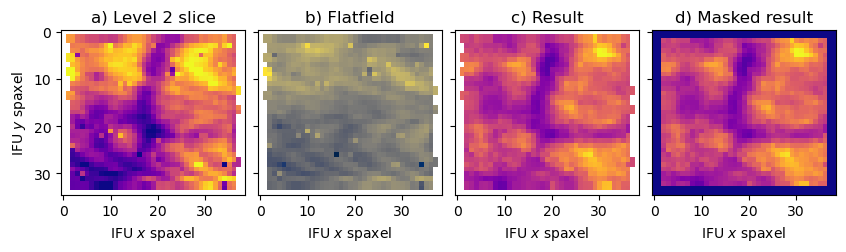

In [38]:
flat = fits.getdata('/Users/hpm5/Documents/Data/nirspec_inspect/flatfield/G395H_flatfield.fits')
wave = l2geos[0].get_wavelength()
nn = 1026
nnn = 5
fig, axs = plt.subplots(1, 4, figsize = (10,5), sharey=True)
fig.subplots_adjust(wspace = 0.07)
whl = np.argwhere(wave > 3.54244).flatten()
print(whl[0])
print(wave[nn])
print(np.nanmax(l2geos[nnn].im[nn, :, :]))
print(np.nanmax(flat[nn, :, :]))
print(np.nanmax(l2geos[nnn].im[nn, :, :] / flat[nn, :, :]))

vmin = 400
vmax = 800

axs[0].imshow(l2geos[nnn].im[nn, :, :], cmap='plasma', vmin = vmin, vmax=vmax)
axs[1].imshow(flat[nn, :, :], cmap='cividis')
axs[2].imshow(l2geos[nnn].im[nn, :, :] / flat[nn, :, :], cmap = 'plasma', vmin = vmin, vmax=vmax)
axs[3].imshow(smallmask(l2geos[nnn].im[nn, :, :] / flat[nn, :, :]), cmap = 'plasma',  vmin = vmin, vmax=vmax)

#divider = make_axes_locatable(axs[2])
#cax = divider.append_axes("right", size="8%", pad=0.09)
#fig.colorbar(imh3p2, cax=cax, label = 'H$_3^+$ Radiance ($\mu$Wm$^{-2}$sr$^{-1}$)')

axs[0].set(ylabel = 'IFU $y$ spaxel', title='a) Level 2 slice')
axs[1].set(title = 'b) Flatfield')
axs[2].set(title = 'c) Result')
axs[3].set(title = 'd) Masked result')
for ax in axs : 
    ax.set(xlabel = 'IFU $x$ spaxel')

plt.savefig('figures/ERS_GRS_flatfield_process.pdf', bbox_inches = 'tight')


(3610,)
/Users/hpm5/anaconda3/envs/jwst/lib/python3.11/site-packages/h3ppy
(4, 3610)


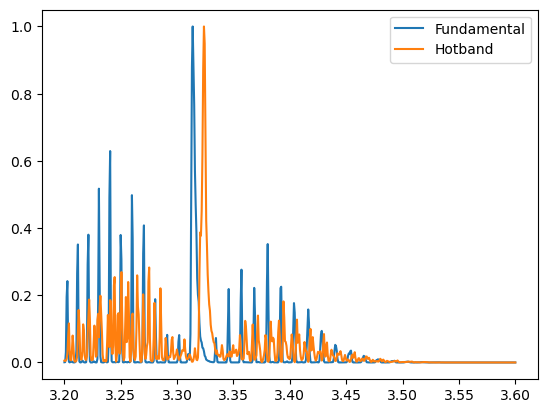

In [50]:
reload(ch4)

ch4list = Table.read('ch4_line_list.txt', format='ascii')
ch4fit = ch4.methane_fitting(ch4list, R = 1600)
file = '/Users/hpm5/Documents/Data/3665_all/jw03665032001_02101_g395h-f290lp_s3d.fits'

geo = jssp.JWSTSolarSystemPointing(file)
wave = geo.get_wavelength()
print(wave.shape)
ch4fit.set_data(wave, wave, wave)
model = ch4fit.methane_spectrum_fn(wave, 1.0, 100.0, 0, 0, 0, 0)
ch4_fun = ch4fit.methane_fundamental_fn()
ch4_fun = ch4_fun / np.nanmax(ch4_fun)
ch4_hot = ch4fit.methane_hotband_fn()
ch4_hot = ch4_hot / np.nanmax(ch4_hot)

h3p = h3ppy.h3p()
h3p.set(wave = wave, T = 800, N = 1e16, R = 2700)
model = h3p.model()
model = model / np.max(model)


fits.writeto('models/methane_fundamental_hotband.fits', np.array([wave, ch4_fun, ch4_hot, model]), overwrite=True)

arr = fits.getdata('models/methane_fundamental_hotband.fits')
print(arr.shape)
fig, ax = plt.subplots()
#ax.plot(wave, arr[0, :])
whw = np.argwhere((wave > 3.2) & (wave < 3.6)).flatten()
ax.plot(wave[whw], arr[1, whw], label = 'Fundamental')
ax.plot(wave[whw], arr[2, whw], label = 'Hotband')
#ax.plot(wave[whw], arr[3, whw], label = 'H3+')
#ax.set(xlim = [3.2, 3.5])
ax.legend()


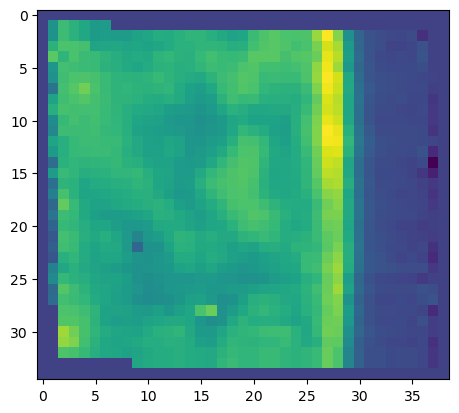

In [66]:
im = fits.getdata('/Users/hpm5/Documents/Data/3665_methane_fits/jw03665020001_02101_00003_g395h-f290lp_s3d.fits', ext=1)
fig, ax = plt.subplots()
ax.imshow(im)